### Computational Guided Inquiry for Modeling Earth's Climate (Neshyba, 2025)

## Overview
Here we show how parameters of Cambio are obtained. This includes parameters of the model itself as well as quantities defining the state of the climate, as needed for self-consistency.

Cambio equations are based on NASA's carbon mass balance diagram, shown in Fig. 1.

<p style='text-align: center;'>    
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/carbon_cycle.jpg" height="500" width="500"/>
Figure 1. NASA's carbon mass balance diagram.
</p>

The Cambio4.0 model is defined by the following five equations:

$$
F_{land->atm} =  k_{la} \ \ \ (1)
$$

$$
F_{atm->land} = k_{al0} +  k_{al1} \times \sigma_{floor,CO_2}(T_{anomaly}) \times C_{atm} \ \ \ (2)
$$

$$
F_{ocean->atm} = k_{oa} \times (1+DC\times T_{anomaly}) \times C_{ocean} \ \ \ (3)
$$

$$
F_{atm->ocean} = k_{ao} C_{atm} \ \ \ (4) 
$$

$$
F_{human->atm} = \epsilon(t) \ \ \ (5)
$$

The number of parameters required increases as the version number of Cambio goes up. For example, $DC$ appearing in Eq. 3 (which represents the lowered solubility of $CO_2$ in the oceans with increasing temperature) is assumed to be zero in Cambio1.0, but nonzero in higher versions. 

### Part 1 - Parameters not involved in temperature feedback
Part 1 below computes the following parameters (all of which appear explicitly in these equations): $k_{la}$, $k_{al0}$, $k_{al1}$, $k_{oa}$, and $k_{ao}$. Part 1 also computes 
- $k$, the growth rate of carbon emissions, based on historical emission data (needed to compute $k_{oa}$); and 
- $C_{ocean,preind}$, the pre-industrial ocean carbon reservoir.

Also of interest will be the excess amounts of carbon in the atmosphere and ocean reservoirs, 

$$
\Delta C_{atm} \equiv C_{atm} - C_{atm}^o \ \ \ (6)
$$

$$
\Delta C_{ocean} \equiv C_{ocean} - C_{ocean}^o \ \ \ (7)
$$

whose dynamics obey 

$$
 {d (log(\Delta C_{atm})) \over dt} = {1 \over \Delta C_{atm}} { {d \Delta C_{atm} \over dt}}= {1 \over \Delta C_{atm}} { {d C_{atm} \over dt}}=k \ \ \ (8)
$$

$$
 {d (log(\Delta C_{ocean})) \over dt} = {1 \over \Delta C_{ocean}} { {d \Delta C_{ocean} \over dt}}= {1 \over \Delta C_{ocean}} { {d C_{ocean} \over dt}}=k \ \ \ (9)
$$

### Part 2 - Parameters involved in temperature feedback
Cambio versions higher than Cambio1.0 implement an increasing number of feedbacks:

- Cambio2.0 incorporates Henry's feedback between oceans and the atmosphere, whereby warmer oceans more readily outgas dissolved $CO_2$.
- Cambio3.0 incorporates ice-albedo feedback.
- Cambio4.0 incorporates the reduction in $CO_2$ fertilization with increasing temperature.

Part 2 describes the algorithms and their parameters that are involved in these feedbacks. Two of these are linear functions,
- the temperature anomaly, $T_{anomaly}$, described as a linear function of changes in atmospheric $CO_2$ amount and albedo; and
- the Henry's coefficient, $DC$, described as a linear function of temperature, based on data in https://demonstrations.wolfram.com/TemperatureDependenceOfHenrysLawConstant/.

After describing a generic sigmoid function, $\sigma_{floor}$, and the parameters that control it (e.g., the threshold and abruptness of a transition), Part 2 also parameterizes 
- the global albedo reduction due to temperature increase, using $\sigma_{floor}(T_{anomaly})$; and
- the reduction in $CO_2$ fertilization due to temperature increases, also using $\sigma_{floor}(T_{anomaly})$.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import meclib.cl as cl
from copy import copy as makeacopy
from scipy import optimize
from numpy import genfromtxt
from scipy.optimize import curve_fit
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity

In [91]:
%matplotlib inline
fontsize = 14

## Earth's effective emissivity

In [93]:
T_preind = 288
alpha = 0.3
S = 1367
sigma = 5.67e-8
emissivity = S*(1-alpha)/(4*sigma*T_preind**4)
print('effective emissivity =', emissivity)

effective emissivity = 0.6132725883622753


## Part 1. Parameters not involved in temperature feedback

### Determining $k_{la}$, $k_{al0}$ and $k_{al1}$
Referring to Eq. 1, and using the NASA carbon flows figure, we set $k_{la}=F_{land->atm}=120 \ GtC/year$, unchanged from preindustrial within the model. In fact, the choice of $k_{la}=120 \ GtC/year$ cancels out when computing net fluxes. Its value can be overwritten in cl.CreateClimateParams, with no effect beyond the specification of the one-way fluxes $F_{la}$ and $F_{al}$.

Regarding Eq. 2, we will need $F_{atm->land}$ at two different times, presenting us with two simultaneous equations to solve, ignoring for the moment the sigmoid function (i.e., set $\sigma_{floor}=1$) because this only comes into play in Cambio4.0. Thus we have 

$$
F_{atm->land,2003} = k_{al0} +  k_{al1} \times C_{atm,2003}
$$

$$
F_{atm->land,preind} = k_{al0} +  k_{al1} \times C_{atm,preind}
$$

In the year 2003, we will set $F_{land->atm}=123 \ GtC/year$ (according to the NASA figure). The preindustrial value is $F_{land->atm}=120 \ GtC/year$. Hougton tell us $C_{atm,2003}=780 \ GtC$, and we also know that preindustrially, the atmospheric concentration of $CO_2$ was $274 \ ppm$, which translates to $615 \ GtC$. Therefore we have all the information we need to solve for $k_{al0}$ and $k_{al1}$.

We also report below the inverse of $k_{al1}$, which is a characteristic time.

In [96]:
# Land-to-atmosphere fluxes and constant (Eq. 1 of Cambio1.0), according to NASA's figure 
F_la_2003 = F_al_preind = F_la_preind = k_la = 120

# Atmosphere-to-land flux
F_al_2003 = F_la_2003 + 3

print('For Eq. 1:')
print('k_la =',k_la)
print('')

# Pre-industrial carbon in the atmosphere, and amount in the atmosphere at the time of the NASA figure (2003)
# C_atm_preind = 615
C_atm_preind = 278*2.124; print('C_atm_preind', C_atm_preind) # Ballantyne et al., 2012
C_atm_preind = np.round(C_atm_preind); print('C_atm_preind', C_atm_preind) 
C_atm_2003 = 780

# Atm-to-land flux constants (Eq. 2 of Cambio1.0, using NASA's 2003 atm->land fluxes 
# and reservoir amounts in pre-industrial time and 2003)
k_al1 = (F_al_2003-F_al_preind)/(C_atm_2003-C_atm_preind)
k_al0 = F_al_preind-k_al1*C_atm_preind
print('For Eq. 2:') 
print('k_al0 =', k_al0)
print('k_al1 =', k_al1,'yr^-1')
print('')
print('Related quantity:')
print('1/k_al1 =',1/k_al1,'yr')
print('')
print('Checking:')
print('Atm-to-land flux (pre-industrial) = ', k_al0+k_al1*C_atm_preind)
print('Atm-to-land flux (2003) = ', k_al0+k_al1*C_atm_2003)
print('Atm-to-land net flux (pre-industrial)',k_al0+k_al1*C_atm_preind-F_la_preind)
print('Atm-to-land net flux (2003)',k_al0+k_al1*C_atm_2003-F_la_2003)

For Eq. 1:
k_la = 120

C_atm_preind 590.472
C_atm_preind 590.0
For Eq. 2:
k_al0 = 110.6842105263158
k_al1 = 0.015789473684210527 yr^-1

Related quantity:
1/k_al1 = 63.33333333333333 yr

Checking:
Atm-to-land flux (pre-industrial) =  120.0
Atm-to-land flux (2003) =  123.0
Atm-to-land net flux (pre-industrial) 0.0
Atm-to-land net flux (2003) 3.0


### Using NASA's 2003 atmosphere-to-ocean flux to find $k_{ao}$. 
Referring to Eq. 4 (we'll come back to Eq. 3), and using the NASA carbon flows figure for the atmospheric amount of $C_{atm}$, and an atmosphere-to-ocean flux of $F_{atm->ocean} = 92 {GtC \over year}$, we compute $k_{ao}$. We also report the inverse of $k_{ao}$, which is a characteristic time.

In [98]:
# Atmosphere-to-ocean (Eq. 4 of Cambio1.0, using NASA's 2003 atm->ocean flux and 
# atmospheric reservoir amount)
F_ao = 92
k_ao = F_ao/C_atm_2003
print('For Eq. 4:') 
print('k_ao =', k_ao,'yr^-1')
print('')
print('Related quantity:')
print('1/k_ao =',1/k_ao,'yr')

For Eq. 4:
k_ao = 0.11794871794871795 yr^-1

Related quantity:
1/k_ao = 8.478260869565217 yr


### Using historical emission data to find $k$
Referring to Eq. 5, if we assume an exponential growth in anthropogenic emissions,

$$
F_{human->atm} = \epsilon(t) \approx N e^{kt}
$$

then we can match to historical $CO_2$ emissions from fossil fuels and land-use change (appearing in second graph at https://ourworldindata.org/co2-emissions), and perform a least-squares fit to obtain $k$. As shown below, the result is $k=0.0166 \ yr^{-1}$, corresponding to a time constant of 60 yr.

2003.0 9.123212261580381
k = 0.01657615227648579  1/yr
1/k = 60.32763112453767  yr
k (after rounding = 0.0166


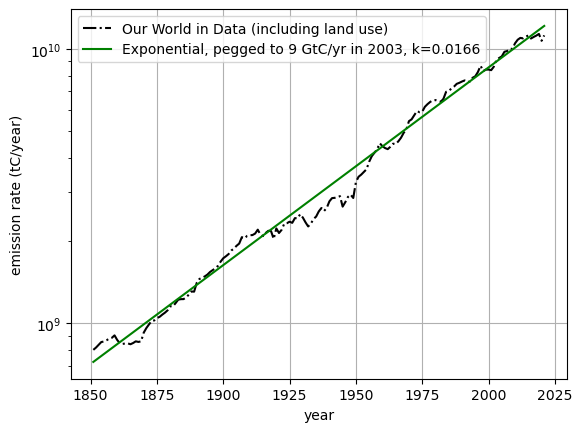

In [100]:
# Load the data
my_data = genfromtxt('Global emissions with land use.csv', delimiter=',')
time_ourworldindata = my_data[1:,0]
eps_ourworldindata = my_data[1:,1]/3.67 # Converts tCO2 to GtC

# Defining a function to use for least-squares fitting (there are easier ways of doing this)
def linfun(x,a,b):
    return a*x+b

# Fitting
logeps_ourworldindata = np.log(eps_ourworldindata)
popt, pcov = curve_fit(linfun, time_ourworldindata, logeps_ourworldindata)
k_ourworldindata = popt[0]

# Pegging the theoretical curve (exponential) to emissions in 2003
cambio_t0 = 2003
cambio_eps0 = 9e9
cambio_k = round(k_ourworldindata,4); 
cambio_eps = np.exp(cambio_k*time_ourworldindata)/np.exp(cambio_k*cambio_t0)*cambio_eps0

# Taking a look
plt.figure()
plt.semilogy(time_ourworldindata,eps_ourworldindata,'k-.',label='Our World in Data (including land use)')
plt.semilogy(time_ourworldindata,cambio_eps, 'g', label='Exponential, pegged to 9 GtC/yr in 2003, k='+str(cambio_k)[0:6])
plt.grid(True)
plt.xlabel('year')
plt.ylabel('emission rate (tC/year)')
plt.legend()

# Checking the observed emission in the pegged year
i2003 = 152
print(time_ourworldindata[i2003],eps_ourworldindata[i2003]/1e9)

print('k =',k_ourworldindata, ' 1/yr')
print('1/k =', 1/k_ourworldindata, ' yr')

# Going forward we might call this "k" 
k = cambio_k 
print('k (after rounding =', k)

### Using NASA's ratio of net ocean sequestration to net land sequestration to find $k_{oa}$
The ratio of net carbon flux to the ocean vs to land is defined by

$$
r = {\Delta F_{ao} \over \Delta F_{al}} \ \ \ (A1)
$$

where $\Delta F_{ao} = F_{atm->ocean}-F_{ocean->atm}$ and $\Delta F_{al} = F_{atm->land}-F_{land->atm}$. This can be approximated as 

$$
r \approx {k k_{ao} \over k_{al1}(k+k_{oa})} \ \ \ (A2)
$$

How? Our equations of motion say that 

$$
\Delta F_{ao} = {dC_{ocean} \over dt} = k_{ao}C_{atm} - k_{oa}C_{ocean} \ \ \ (A3)
$$

Our "empirical result" (see code below) says 

$$
{d \ ln(\Delta C_{ocean}) \over dt} = {1 \over \Delta C_{ocean}} {d\Delta C_{ocean} \over dt} \approx k \ \ \ (A4)
$$

where $\Delta C_{ocean} = C_{ocean}-C_{ocean}^o$. But ${d\Delta C_{ocean} \over dt}={dC_{ocean} \over dt}$, so 

$$
\Delta F_{ao} = k \Delta C_{ocean} = k (C_{ocean}-C_{ocean}^o) \ \ \ (A5)
$$

Combining A3 and A5 yields

$$
C_{ocean} = {1 \over k+k_{oa}}\bigl( kC_{ocean}^o+k_{ao}C_{atm} \bigr ) \ \ \ (A6)
$$

which means we can write the numerator of Eq. A1 as 

$$
\Delta F_{ao} = k\bigl({1 \over k+k_{oa}} (k C_{ocean}^o+k_{ao}C_{atm})-C_{ocean}^o\bigr) \ \ \ (A7)
$$

Our equations of motion for atmosphere-land exchange say that the denominator of Eq. A1 is given by

$$
\Delta F_{al} = k_{al0}+k_{al1}C_{atm}-k_{la} \ \ \ (A8)
$$

This means we can express A1 as 

$$
r = {k\bigl({1 \over k+k_{oa}} (k C_{ocean}^o+k_{ao}C_{atm})-C_{ocean}^o\bigr) \over k_{al0}+k_{al1}C_{atm}-k_{la}} \ \ \ (A9)
$$

Now we want to take the limit of big $C_{atm}$. To do that, we divide top and bottom of Eq. A9 by $C_{atm}$, and take that limit, giving the desired relationship (Eq. A2). In fact, we'll want to invert that relationship, to 

$$
k_{oa} = k \bigl ( { k_{ao} \over r k_{al1}} -1 \bigr ) \ \ \ (A10)
$$

For example, in the cell below, use of $r=2/3$ (from the NASA figure for the year 2003) yields $k_{oa}=0.16 \ yr^{-1}$. 

In [102]:
# NASA's observed ratio of net ocean sequestration to net land sequestration
r = 2/3 

# Ocean-to-atmosphere flux constant based on Cambio1.0 equations, constrained
# to satisfy the ratio r
print('For Eq. 3:') 
k_oa = k*(k_ao/(r*k_al1)-1)
print('k_oa =', k_oa,'yr^-1')
print('')
print('Related quantities:')
print('t_oa =',1/k_oa,'yr')

For Eq. 3:
k_oa = 0.1694051282051282 yr^-1

Related quantities:
t_oa = 5.903009021008658 yr


As a check on the foregoing, we can also calculate $r$ from the results of a numerical solution. That is done at the bottom of this notebook, with the following results (expecting $r=0.67$): 
- Cambio1.0 yields $r_{numerical}=0.68$
- Cambio2.0 yields $r_{numerical}=0.60$
- Cambio3.0 yields $r_{numerical}=0.60$
- Cambio4.0 yields $r_{numerical}=0.60$

### Finding the pre-industrial ocean carbon reservoir
Here we use the above constants to calculate what the ocean carbon reservoir must have been in order to have been in steady-state in pre-industrial times.

In [105]:
# Atmosphere-to-ocean flux, pre-industrial, according to k_oa just obtained
F_ao_preind = k_ao * C_atm_preind
print('F_ao_preind =', F_ao_preind)

# Ocean-to-atmosphere flux assuming preindustrial steady state
F_oa_preind = F_ao_preind

# Implied pre-industrial ocean carbon reservoir
C_ocean_preind = F_oa_preind/k_oa
print('C_ocean_preind =',C_ocean_preind)

print('')
print('Related quantities and checks:')

C_ocean_2003_est = C_atm_2003*k_ao/k_oa
print('C_ocean_2003 (estimated) =',C_ocean_2003_est)

# Known fluxes and concentrations in 1750
# C_atm_1750 = 615
C_atm_1750 = C_atm_preind
Fao_1750 = k_ao * C_atm_1750; print('Just checking ... atmosphere -> ocean flux in 1750 =', Fao_1750)

# Let's assume equilibration of GCC's ocean mixed layer with the atmosphere  
C_ocean_2003_assumed = 1000
F_oa_2003 = 90
k_oa_2003_check = F_oa_2003/C_ocean_2003_assumed; print('Just checking ... k_oa based on 2003 =', k_oa_2003_check)

# In that case, we can back out what the ocean had back in 1750
F_oa_preind_check = F_ao_preind
C_ocean_preind_check = F_oa_preind_check/k_oa; print('Just checking ... C_ocean_preind =', C_ocean_preind_check)

F_ao_preind = 69.58974358974359
C_ocean_preind = 410.78888417993585

Related quantities and checks:
C_ocean_2003 (estimated) = 543.0768299327965
Just checking ... atmosphere -> ocean flux in 1750 = 69.58974358974359
Just checking ... k_oa based on 2003 = 0.09
Just checking ... C_ocean_preind = 410.78888417993585


## Part 2 - Parameters involved in temperature feedbacks

### Diagnosing temperature anomaly from changes in atmospheric $CO_2$ and albedo
Implementing temperature feedbacks requires an algorithm for computing a temperature anomaly from changes in albedo and atmospheric carbon amount. The algorithm used in all Cambio codes is the bilinear form

$$
T_{anomaly} = CS\times\Delta C_{atm}+AS\times\Delta \alpha \ \ \ (B1)
$$

where $\Delta C_{atm}=C_{atm}-C_{atm,preind}$, $\Delta \alpha = \alpha-\alpha_{preind}$, and $\alpha_{preind}=0.3$. $CS$ in this equation is the climate sensitivity parameter, obtained using the assumption 3 degrees warming for a doubling of atmospheric $CO_2$, which corresponds to $CS={3 \over 590} = 0.00508 {^\circ C \over GtC}$. $AS$ is the albedo sensitivity parameter, determined from a simple radiative balance model, which equates incoming shortwave radiance ($\dfrac{S_0}{4}(1-\alpha)$) to outgoing longwave radiance ($\kappa \sigma T^4$, with $\kappa=0.614$), yielding $AS=-102.8 ^\circ C$. (See the cell below).

287.91466299374713 14.914662993747129
AS = -102.82666535490968
CS = 0.005084745762711864


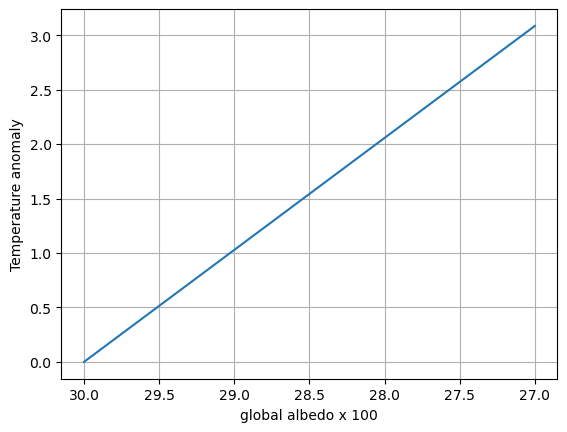

In [108]:
# Albedo sensitivity
alpha0 = 0.3
S0 = 1367
kappa = 0.614
sigma = 5.67e-8
Teq = (S0/4*(1-alpha0)/(kappa*sigma))**.25; print(Teq,Teq-273)
AS = -1/4*(S0/4*(1-alpha0)/(kappa*sigma))**(.25-1)*S0/4/(kappa*sigma); print('AS =', AS)

# Climate (carbon) sensitivity
CS = 3/C_atm_preind; print('CS =', CS)

# Let's take a look
Delta_albedo = np.linspace(0,alpha0*0.9-alpha0)
albedo = alpha0+Delta_albedo
T_anomaly_from_formula = AS*Delta_albedo
plt.figure()
plt.plot(albedo*100,T_anomaly_from_formula)
plt.grid(True)
plt.xlabel('global albedo x 100')
plt.ylabel('Temperature anomaly')
plt.gca().invert_xaxis()

### Finding $DC$, which determines the T-dependence of ocean-to-atmosphere $CO_2$ discharge, using Henry's Law
Going back to Eq. 3, recall that $DC$ was assumed to be zero in Cambio1.0, meaning there is no accounting for a temperature dependence of the outgassing of carbon in the ocean to the atmosphere. Cambio2.0 implements this  via a temperature-dependent Henry's constant formulation,

$$
H = H_o + DC' \times \Delta T \ \ \ (C1)
$$

where $H_o = H$ at some reference temperature. 

First we'll take estimates from the graph at https://demonstrations.wolfram.com/TemperatureDependenceOfHenrysLawConstant/. If we say the reference temperature is the pre-industrial global mean temperature, $T_o=15°C$, then according to the graph, $H_o=1220 \ atm$ and $DC'={2200-1220 \over 40-15} \ {atm \over K}$ (slope of $H(T)$ at $T_o$).

For our problem, equilibrium at $T_o$ means equal fluxes, $F_{ao}=F_{oa}$, therefore (according to Eqs. 3 and 4, with $\Delta T=0$), we have

$$
{C_{atm} \over C_{ocean}} = {k_{oa}^o \over k_{ao}} \propto H_o + DC' \times \Delta T \ \ \ (C2)
$$

where $k_{oa}^o=k_{oa}(\Delta T=0)$, equal to the expression given in Eq. A10 (i.e., the pre-industrial value of $k_{oa}$). Then the temperature dependence would be given by

$$
k_{oa}^o \times (1 + DC \times \Delta T) = k_{oa}^o \times {1 \over H_o} \times (H_o + DC' \times \Delta T) \ \ \ (C3)
$$

which means 

$$
DC = {DC' \over H_o}
$$

In [110]:
# Relative change in Henry's constant for CO2 
DCprime = (2200-1220)/(40-15); print(DCprime)
H0 = 1220
DC = DCprime/H0; print(DC)

39.2
0.03213114754098361


### Henry's coefficient - using the analytical form
See https://demonstrations.wolfram.com/TemperatureDependenceOfHenrysLawConstant/. Here's what Wolfram says:

Henry's law was originally formulated by William Henry in 1803. This law describes the solubility of gases in liquids. Henry's law states that at constant temperature, the mole fraction of a given gas dissolved in the liquid, x, is directly proportional to the partial pressure of that gas (i.e.,

$$
Py=Hx
$$

where
P is the total pressure, H is the Henry's law constant, and y is the vapor-phase mole fraction). Wolfram says 

$$
H={1 \over e^{A+B/T+C ln(T)+DT}}
$$

where A, B, C, and D are constants that depend on the chemical species considered (also provided by Wolfram).

DC =  0.031305789091437976


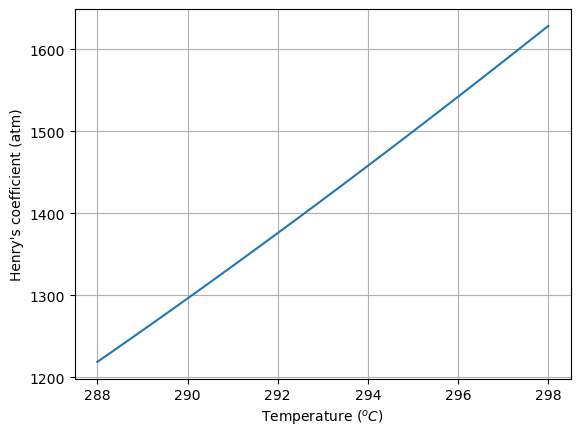

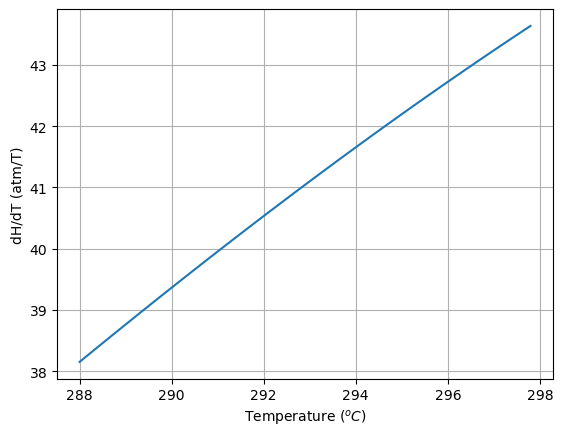

In [112]:
def Henry_CO2(T):
    AH = -159.854; BH = 8741.68; CH = 21.6694; DH = -1.10261e-3; Tcap = 353
    return 1/np.exp(AH + (BH/(T)) + CH*np.log(T) + DH*(T))

# T_Henry_C = np.linspace(0,20,100)
# T_Henry_K = T_Henry_C + 273.15
T_Henry_K = np.linspace(288,298)
myHenry_CO2 = Henry_CO2(T_Henry_K)

dT_Henry = T_Henry_K[1]-T_Henry_K[0]
myDCbar_CO2 = np.diff(myHenry_CO2)/dT_Henry

plt.figure()
plt.plot(T_Henry_K,myHenry_CO2)
plt.grid(True)
plt.xlabel('Temperature ($^oC$)')
plt.ylabel("Henry's coefficient (atm)")

plt.figure()
plt.plot(T_Henry_K[0:-1],myDCbar_CO2)
plt.grid(True)
plt.xlabel('Temperature ($^oC$)')
plt.ylabel("dH/dT (atm/T)")

myDC = myDCbar_CO2[0]/myHenry_CO2[0]
print("DC = ", myDC)


### NIST data for Henry's Law
https://webbook.nist.gov/cgi/cbook.cgi?ID=C124389&Mask=10

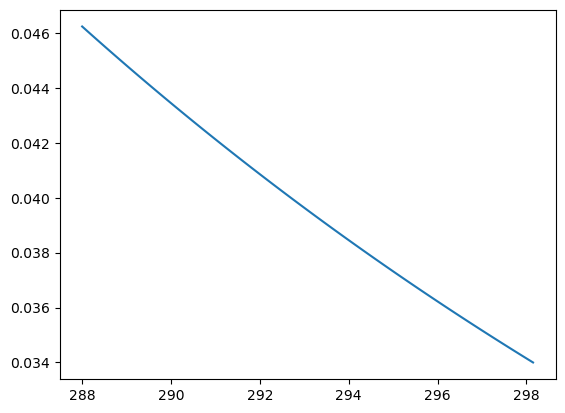

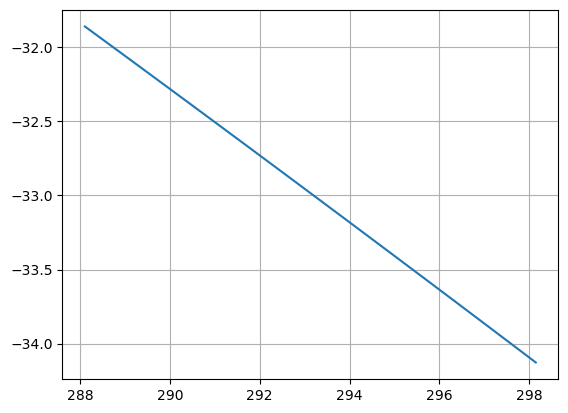

In [114]:
koH_ref = 0.034 # units mol/(kg bar)
T_ref = 298.15 # units K
T_for_Henry = np.linspace(288,T_ref,100)
T_dependence_constant = 2600 # units K
kH = koH_ref*np.exp(T_dependence_constant*(1/T_for_Henry-1/T_ref))
dkH_dT = np.diff(kH)/np.diff(T_for_Henry)

plt.figure()
plt.plot(T_for_Henry,kH)
plt.figure()
plt.plot(T_for_Henry[1:],kH[1:]/dkH_dT)
plt.grid(True)

### Parameterizing a generic $\sigma_{floor}$
Going back to Eq. 2, recall that we deferred discussing parameterization of the sigmoid function in that expression, because this only comes into play in Cambio4.0. Before entering that context, however, we will define a generic sigmoid function, $\sigma_{floor}$, and develop parameters for it, that we will use in Cambio. 

The mathematical formulation is 

$$
\sigma = \bigl ( 1 - {1 \over 1 + e^{-3(x-x_{thresh})/x_{trans}}} \bigr )(1-\sigma_{x,+\infty})+\sigma_{x,+\infty}
$$

$\sigma$ replaces $\sigma_{floor}$ has three parameters. They are the same function, but the arguments are named differently:

1. $x_{thresh}$ (called $x_{trans}$ by $\sigma_{floor}$) is the sigmoid's transition or threshold value, where the sigmoid is half-way from its starting value to its ending value;  
1. x_{trans} (called $x_{interval}$ by $\sigma_{floor}$) is the interval of $x$ over which approximately $90\%$ of the transition to the the half-way point takes place; and 
1. $\sigma_{x,+\infty}$ (called $\sigma_{floor,\infty}$ by $\sigma_{floor}$) is the final value of the sigmoid function (the initial value is 1).

Some generic examples are displayed in a code cell below. 

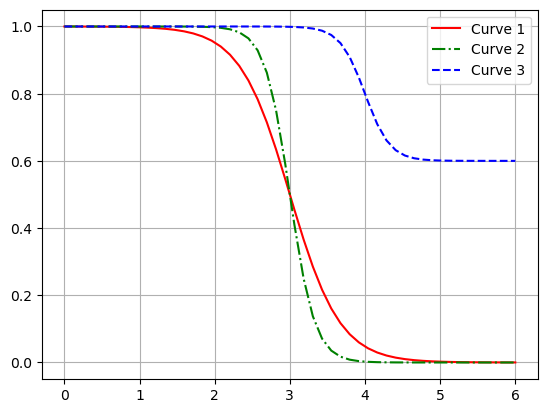

In [116]:
x = np.linspace(0,6)
plt.figure()
plt.plot(x,cl.sigmoid(x,x_thresh=3,x_trans=1,  sigma_x_infinity=0),'r',label='Curve 1')
plt.plot(x,cl.sigmoid(x,x_thresh=3,x_trans=0.5,sigma_x_infinity=0),'g-.',label='Curve 2')
plt.plot(x,cl.sigmoid(x,x_thresh=4,x_trans=0.5,sigma_x_infinity=0.6),'b--',label='Curve 3')
plt.grid(True)
plt.legend()
# plt.xlabel('x')
# plt.ylabel('sigma_floor(x)')

### Representing loss of Arctic ice with a sigmoid function of the temperature anomaly
Wunderly et al, 2020 (https://www.nature.com/articles/s41467-020-18934-3) estimate the global temperature impact of a transition to a climate state in which summertime Arctic ice and alpine glaciers are lost, in addition to a limited decline of WAIS and Greenland ice. Their result is an additional global warming of $+0.43 K$. 

We represent this transition in Cambio3.0 as a sigmoidal albedo effect, as follows. First, we compute the  change in the global albedo that would produce that warming, 

$$
\Delta \alpha_{ASI} = {0.43 \over -103} = -0.0042 \ \ \ (C1)
$$

We then specify the impact of temperature anomaly on global albedo as a sigmoid function,

$$
\alpha = \alpha_{preind} \times \sigma_{floor,ice-albedo}(T_{anomaly}) \ \ \ (C2)
$$

where $\alpha_{preind}=0.3$ and the "floor" parameter of $\sigma_{floor,ice-albedo}$ is given by

$$
\sigma_{floor,\infty,T_{anomaly}} = 1 + \Delta \alpha_{ASI}/\alpha_{preind} = 0.986 \ \ \ (C3)
$$

The other two parameters of $\sigma_{floor,ice-albedo}$ specify the temperature anomaly at which this transition is half-way complete ($T_{anomaly,\alpha, trans}=2 ^oC$), and the abruptness of that transition ($T_{anomaly,\alpha, interval}=0.5 ^oC$). This representation can be summed up as follows: as long as $T_{anomaly}<1.5 ^oC$, global albedo will remain close to its pre-industrial value of $\alpha_{preind}=0.3$, but once $T_{anomaly}>2.5 ^oC$, global albedo will fall to $\alpha \approx 0.3-0.004=0.296$.

Predicted global albedo change after loss of Arctic ice = -0.004181794659156169
fractional floor = 0.9860606844694794
global albedo after loss of ice 0.2958182310345204
global albedo change after loss of ice -0.004181743271803096


Text(0.5, 1.0, 'global albedo changes from loss of summertime Arctic sea ice')

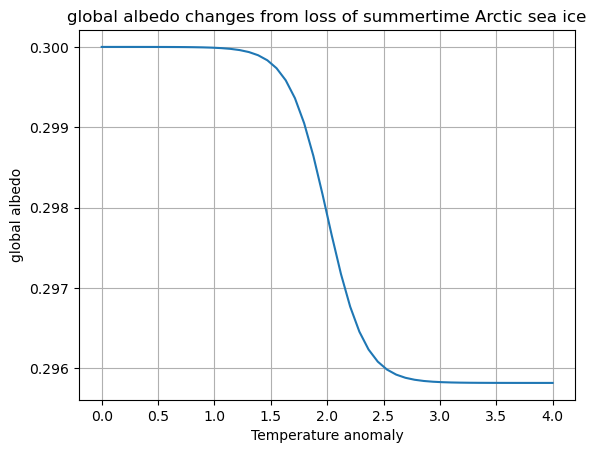

In [118]:
T_anomaly_ASI = 0.43
Delta_alpha_ASI = T_anomaly_ASI/AS
print('Predicted global albedo change after loss of Arctic ice =', Delta_alpha_ASI)
albedo_Tstar = 2
T_anomaly = np.linspace(0,2*albedo_Tstar)
albedo_deltaT = 0.5
preindustrial_albedo = 0.3
fractional_albedo_floor = (preindustrial_albedo+Delta_alpha_ASI)/preindustrial_albedo
print('fractional floor =', fractional_albedo_floor)
albedo = preindustrial_albedo*cl.sigmafloor(T_anomaly,albedo_Tstar,albedo_deltaT,fractional_albedo_floor)
print('global albedo after loss of ice', albedo[-1])
print('global albedo change after loss of ice', albedo[-1]-albedo[0])
plt.figure()
plt.plot(T_anomaly,albedo)
plt.grid(True)
plt.xlabel('Temperature anomaly')
plt.ylabel('global albedo')
plt.title('global albedo changes from loss of summertime Arctic sea ice')

### Parameterization of the temperature dependence of $CO_2$ fertilization
The cells below are meant to adjust parameters controlling the temperature dependence of $CO_2$ fertilization, i.e., the term $k_{al1} \times \sigma_{floor,CO_2}(T_{anomaly})$ appearing in Eq. 2. Those parameters will be adjusted to match the net atmosphere-to-land flux report reported by Ke et al, 2024 (https://academic.oup.com/nsr/article/11/12/nwae367/7831648).

We start with two functions that reproduce Cambio4 that are tailored to be used by Python's optimize functionality.

In [120]:
# Function to return just the net atmosphere-to-land flux of Cambio4
def get_net_fluxes_Cambio4(ClimateParams,epstime,eps):
    
    # Make the starting state the preindustrial
    ClimateState = cl.CreateClimateState(ClimateParams)

    # Initialize our list of climate states 
    ClimateState_list = []

    # The time interval
    dt = epstime[1]-epstime[0]

    # Loop over all the times after the initial one in the scheduled flow
    for i in range(1,len(epstime)):

        # Propagate
        ClimateState = cl.PropagateClimateState_Cambio4(ClimateState, ClimateParams, dt, eps[i])

        # Add to our list of climate states
        ClimateState_list.append(ClimateState)

    # Extracting data from ClimateState_list
    time_array = cl.CollectClimateTimeSeries(ClimateState_list,'time')
    F_al_array = cl.CollectClimateTimeSeries(ClimateState_list,'F_al')
    F_la_array = cl.CollectClimateTimeSeries(ClimateState_list,'F_la')

    # Compute the net fluxes
    F_land_net = F_la_array-F_al_array
    
    # Return
    return time_array, F_land_net

# Function, callable by optimize.curve_fit, that optimizes values of the sigmoid function in Eq. 2
def funcCambio4(x,k_al1_Tstar,k_al1_deltaT,fractional_k_al1_floor):
    ClimateParams_test = makeacopy(ClimateParams)
    ClimateParams_test['k_al1_Tstar'] = k_al1_Tstar
    ClimateParams_test['k_al1_deltaT'] = k_al1_deltaT
    ClimateParams_test['fractional_k_al1_floor'] = fractional_k_al1_floor
    time_array, F_land_net = get_net_fluxes_Cambio4(ClimateParams_test,time,eps)
    F_land_net_selected = F_land_net[itimes]
    return F_land_net_selected

In [121]:
# Function to return just the net atmosphere-to-land flux of Cambio4
def get_net_fluxes_Cambio3(ClimateParams,epstime,eps):
    
    # Make the starting state the preindustrial
    ClimateState = cl.CreateClimateState(ClimateParams)

    # Initialize our list of climate states 
    ClimateState_list = []

    # The time interval
    dt = epstime[1]-epstime[0]

    # Loop over all the times after the initial one in the scheduled flow
    for i in range(1,len(epstime)):

        # Propagate
        ClimateState = cl.PropagateClimateState_Cambio3(ClimateState, ClimateParams, dt, eps[i])

        # Add to our list of climate states
        ClimateState_list.append(ClimateState)

    # Extracting data from ClimateState_list
    time_array = cl.CollectClimateTimeSeries(ClimateState_list,'time')
    F_al_array = cl.CollectClimateTimeSeries(ClimateState_list,'F_al')
    F_la_array = cl.CollectClimateTimeSeries(ClimateState_list,'F_la')

    # Compute the net fluxes
    F_land_net = F_la_array-F_al_array
    
    # Return
    return time_array, F_land_net

### We'll need an emissions scenario for this.

{'dataframe':             time  emissions
0    1750.000000   0.134987
1    1750.667780   0.136492
2    1751.335559   0.138013
3    1752.003339   0.139552
4    1752.671119   0.141107
..           ...        ...
595  2147.328881   4.000000
596  2147.996661   4.000000
597  2148.664441   4.000000
598  2149.332220   4.000000
599  2150.000000   4.000000

[600 rows x 2 columns], 't_0': 2003, 'eps_0': 9, 't_peak': 2040, 't_decarb': 15, 'k': 0.0166}


{'dataframe':             time  emissions
 0    1750.000000   0.134987
 1    1750.667780   0.136492
 2    1751.335559   0.138013
 3    1752.003339   0.139552
 4    1752.671119   0.141107
 ..           ...        ...
 595  2147.328881   4.000000
 596  2147.996661   4.000000
 597  2148.664441   4.000000
 598  2149.332220   4.000000
 599  2150.000000   4.000000
 
 [600 rows x 2 columns],
 't_0': 2003,
 'eps_0': 9,
 't_peak': 2040,
 't_decarb': 15,
 'k': 0.0166}

{'k_la': 120,
 'k_al0': 110.6842105263158,
 'k_al1': 0.015789473684210527,
 'k_oa': 0.1694051282051282,
 'k_ao': 0.11794871794871795,
 'k': 0.0166,
 'DC': 0.0321,
 'climate sensitivity': 0.005084745762711864,
 'C_atm 2003': 780,
 'F_ao 2003': 92,
 'F_oa 2003': 90,
 'preindustrial C_atm': 590,
 'albedo sensitivity': -102.9948207250004,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': np.float64(1750.0),
 'k_al1_Tstar': 1.43,
 'k_al1_deltaT': 0.471,
 'fractional_k_al1_floor': 0.684,
 'albedo_Tstar': 2,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 0.9860834426115428}

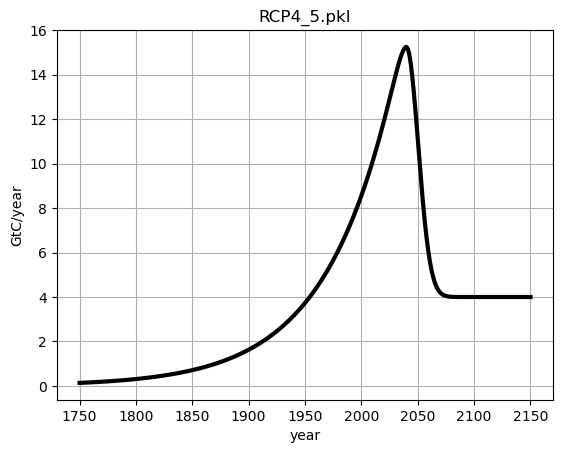

In [149]:
# Here's loading in a scenario, with graphics
# epstime, eps, epsdictionary = cl.GetMyScenario('Peaks_in_2040_bestfitk.hdf5')

filename = 'RCP4_5.pkl'
time, eps, epsdictionary = cl.LoadMyScenario(filename,verbose=True)

# Here's displaying it
display(epsdictionary)

# Getting parameters that depend (in part) on that scenario
ClimateParams = cl.CreateClimateParams(epsdictionary)
display(ClimateParams)

### Next we'll get desired net fluxes that try to incorporate Ke et al's results.

In [152]:
# Get a fresh copy of climate parameters
ClimateParams = cl.CreateClimateParams(epsdictionary)
print('What cl.CreateClimateParams creates, unmodified:')
display(ClimateParams)

# Modify some parameters as initial values for the optimization
ClimateParams['k_al1_Tstar'] = 2
ClimateParams['k_al1_deltaT'] = .5
ClimateParams['fractional_k_al1_floor'] = 1 # Setting this equal to 1 disables any modification to k_al1 

# The following puts the tipping point for albedo way out of range, so albedo won't affect our optimization
# If these two lines of code are omitted, the resulting optimized parameters 
# k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor don't change much (which is good)
ClimateParams['albedo_Tstar'] = 10
ClimateParams['fractional_albedo_floor'] = 1 # "pants = suspenders" 

# See what we have
print('What cl.CreateClimateParams creates, modified for fitting:')
display(ClimateParams)

# Record the fluxes
time_array, F_land_net = get_net_fluxes_Cambio4(ClimateParams,time,eps)

# The following blocs of code select out fluxes (modified according to Ke et al) 
# to be used in the optimization

# Select out some times to focus on fluxes, pre
F_land_net_selected_observed = np.empty(0)
times_pre = np.arange(1950,1985)
itimes_pre = []
for i in range(len(times_pre)):
    itime = np.argmin((time_array-times_pre[i])**2)
    itimes_pre.append(itime)
    F_land_net_selected_observed = np.append(F_land_net_selected_observed,F_land_net[itime])
F_land_net_selected_observed = F_land_net[itimes_pre]

# Select out some times to focus on fluxes, post (values from Ke et al)
times_post = np.arange(2017,2024)
fluxes_post = -np.array([2.4, 1.8, 1.5, 1.3, 1.8, 3.1, 0.44])
print('Mean atmosphere-to-land carbon flux, 2017-2024 =', np.mean(fluxes_post), ' GtC/yr')
itimes_post = []
for i in range(len(times_post)):
    itime = np.argmin((time_array-times_post[i])**2)
    itimes_post.append(itime)
    F_land_net_selected_observed = np.append(F_land_net_selected_observed,fluxes_post[i])

# Concatenate the times
itimes = itimes_pre+itimes_post

What cl.CreateClimateParams creates, unmodified:


{'k_la': 120,
 'k_al0': 110.6842105263158,
 'k_al1': 0.015789473684210527,
 'k_oa': 0.1694051282051282,
 'k_ao': 0.11794871794871795,
 'k': 0.0166,
 'DC': 0.0321,
 'climate sensitivity': 0.005084745762711864,
 'C_atm 2003': 780,
 'F_ao 2003': 92,
 'F_oa 2003': 90,
 'preindustrial C_atm': 590,
 'albedo sensitivity': -102.9948207250004,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': np.float64(1750.0),
 'k_al1_Tstar': 1.43,
 'k_al1_deltaT': 0.471,
 'fractional_k_al1_floor': 0.684,
 'albedo_Tstar': 2,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 0.9860834426115428}

What cl.CreateClimateParams creates, modified for fitting:


{'k_la': 120,
 'k_al0': 110.6842105263158,
 'k_al1': 0.015789473684210527,
 'k_oa': 0.1694051282051282,
 'k_ao': 0.11794871794871795,
 'k': 0.0166,
 'DC': 0.0321,
 'climate sensitivity': 0.005084745762711864,
 'C_atm 2003': 780,
 'F_ao 2003': 92,
 'F_oa 2003': 90,
 'preindustrial C_atm': 590,
 'albedo sensitivity': -102.9948207250004,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': np.float64(1750.0),
 'k_al1_Tstar': 2,
 'k_al1_deltaT': 0.5,
 'fractional_k_al1_floor': 1,
 'albedo_Tstar': 10,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 1}

Mean atmosphere-to-land carbon flux, 2017-2024 = -1.762857142857143  GtC/yr


### Optimization of parameters related to $CO_2$ fertilization
Next we optimize parameters related to $CO_2$ fertilization. funcCambio4 picks up ClimateParams as a global variable rather than having that information come in through an argument list, because I wasn't sure how to do the latter, and this works.

In [155]:
x = []
k_al1_Tstar = ClimateParams['k_al1_Tstar']
k_al1_deltaT = ClimateParams['k_al1_deltaT']
fractional_k_al1_floor = ClimateParams['fractional_k_al1_floor']

# Optimize parameters related to CO2 fertilization
k_al1_Tstar_opt,k_al1_deltaT_opt,fractional_k_al1_floor_opt = \
    optimize.curve_fit(funcCambio4, xdata = x, ydata = F_land_net_selected_observed)[0]
print('parameters k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor')
print('starting:  ', k_al1_Tstar,k_al1_deltaT,fractional_k_al1_floor)
print('optimized: ', k_al1_Tstar_opt,k_al1_deltaT_opt,fractional_k_al1_floor_opt)

parameters k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor
starting:   2 0.5 1
optimized:  1.429297013609816 0.4734763952137283 0.6837800799783833


### Plotting the terrestrial atmosphere-to-land flux 
The cell below plots terrestrial atmosphere-to-land flux as a function of the carbon in the air, with and without terrestrial sequestration feedback as we just parameterized it. We're not deriving any new parameters here, just looking at the effect. 

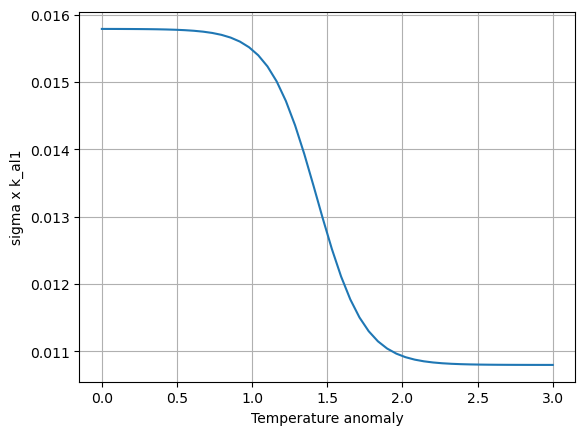

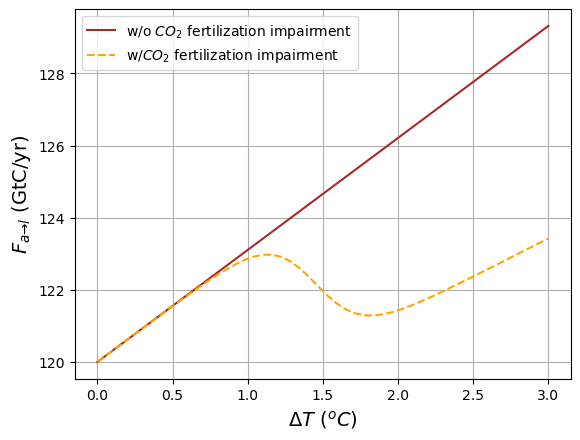

In [157]:
# A range of atmospheric CO2 amounts (preindustrial to 2x that)
C_atm_array = np.linspace(590,2*590)

# Get the temperature anomaly that would result from that, assuming no ice-albedo feedback
T_anomaly = cl.Diagnose_T_anomaly(C_atm_array, 0.3, ClimateParams)

# Plotting the sigmoid function times the CO2 fertilization term to show what that looks like
sigma_test = cl.sigmafloor(T_anomaly,k_al1_Tstar_opt,k_al1_deltaT_opt,fractional_k_al1_floor_opt)
plt.figure()
plt.plot(T_anomaly,sigma_test*ClimateParams['k_al1'])
plt.xlabel('Temperature anomaly')
plt.ylabel('sigma x k_al1')
plt.grid(True)

# Other parameters we'll need for this comparison 
k_al0 = ClimateParams['k_al0']
k_al1 = ClimateParams['k_al1']

# Terrestrial atmosphere-to-land flux with and without terrestrial sequestration feedback
F_al_without_tsf = k_al0 + k_al1*C_atm_array
F_al_with_tsf_extrap = k_al0 + k_al1*C_atm_array*fractional_k_al1_floor_opt
F_al_with_tsf = k_al0 + k_al1*C_atm_array*\
            cl.sigmafloor(T_anomaly,k_al1_Tstar_opt,k_al1_deltaT_opt,fractional_k_al1_floor_opt)

# Plot them side by side as a function of the temperature anomaly
iextrap = int(len(C_atm_array)/2)
C_atm_array_ppm = C_atm_array/2.12
plt.figure()
plt.plot(T_anomaly,F_al_without_tsf,color='brown',label="w/o $CO_2$ fertilization impairment")
plt.plot(T_anomaly,F_al_with_tsf,'--',color='orange',label="w/$CO_2$ fertilization impairment")
plt.xlabel('$\Delta T$ ($^oC$)',fontsize=fontsize)
plt.ylabel('$F_{a→l}$ (GtC/yr)',fontsize=fontsize)
# plt.title('Temperature-dependent CO2 fertilization',fontsize=fontsize)
plt.legend()
plt.grid()

### Running a simulation with Wunderland-informed $CO_2$ fertilization reductions
The code below uses the fully optimized k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor.

ClimateParams as currently returned:
ClimateParams used for this simulation:


{'k_la': 120,
 'k_al0': 110.6842105263158,
 'k_al1': 0.015789473684210527,
 'k_oa': 0.1694051282051282,
 'k_ao': 0.11794871794871795,
 'k': 0.0166,
 'DC': 0.0321,
 'climate sensitivity': 0.005084745762711864,
 'C_atm 2003': 780,
 'F_ao 2003': 92,
 'F_oa 2003': 90,
 'preindustrial C_atm': 590,
 'albedo sensitivity': -102.9948207250004,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': np.float64(1750.0),
 'k_al1_Tstar': np.float64(1.429297013609816),
 'k_al1_deltaT': np.float64(0.4734763952137283),
 'fractional_k_al1_floor': np.float64(0.6837800799783833),
 'albedo_Tstar': 2,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 0.9860834426115428}

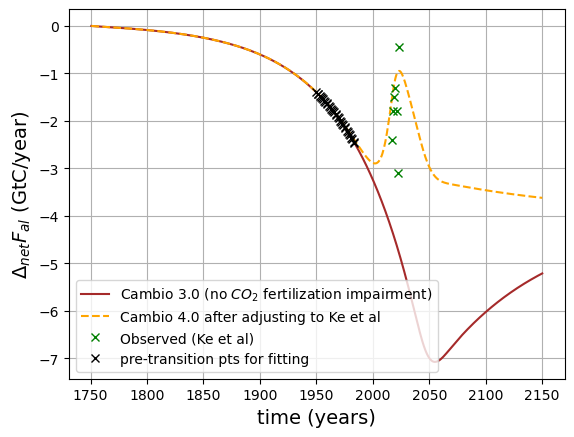

In [161]:
print('ClimateParams as currently returned:')
ClimateParams = cl.CreateClimateParams(epsdictionary)

# Override the CO2 fertilization parameters
ClimateParams['k_al1_Tstar'] = k_al1_Tstar_opt
ClimateParams['k_al1_deltaT'] = k_al1_deltaT_opt
ClimateParams['fractional_k_al1_floor'] = fractional_k_al1_floor_opt

# Reporting
print('ClimateParams used for this simulation:')
display(ClimateParams)

# Run a Cambio4 simulation with these modifications and plot the fluxes
time_array, F_land_net_withfeedback = get_net_fluxes_Cambio4(ClimateParams,time,eps)
time_array, F_land_net_nofeedback = get_net_fluxes_Cambio3(ClimateParams,time,eps)

plt.figure()
plt.plot(time_array,F_land_net_nofeedback,label='Cambio 3.0 (no $CO_2$ fertilization impairment)',color='brown')
plt.plot(time_array,F_land_net_withfeedback,'--',label='Cambio 4.0 after adjusting to Ke et al',color='orange')
plt.plot(times_post,fluxes_post,'x',label='Observed (Ke et al)',color='green')
plt.plot(time_array[itimes_pre],F_land_net[itimes_pre],'x',label='pre-transition pts for fitting',color='k')
plt.xlabel('time (years)',fontsize=fontsize)
plt.ylabel("$\Delta_{net} F_{al}$ (GtC/year)",fontsize=fontsize)
plt.grid(True)
plt.legend()
# plt.plot(time_array,F_land_net,label='Cambio before we knew about Ke et al',color='brown')

### Cambio4.0 with $CO_2$ fertilization reduction informed by Wunderland et al, with current ClimateParams
ClimateParams as currently returned should have k_al1_Tstar, k_al1_deltaT, and fractional_k_al1_floor values close to the optimized ones (they have been rounded), so the results should be close to what we just got.

In [163]:
# CS_Cambio4_list = cl.run_Cambio(cl.PropagateClimateState_Cambio4, ClimateParams, time, eps)

In [164]:
# print('ClimateParams as currently returned:')
# ClimateParams = cl.CreateClimateParams(epsdictionary)

# # Reporting
# print('ClimateParams used for this simulation:')
# display(ClimateParams)

# # Run a Cambio4 simulation with these modifications and plot the fluxes
# time_array, F_land_net_withfeedback = get_net_fluxes_Cambio4(ClimateParams,epstime,eps)
# time_array, F_land_net_nofeedback = get_net_fluxes_Cambio3(ClimateParams,epstime,eps)

# plt.figure()
# plt.plot(time_array,F_land_net_nofeedback,label='Cambio 3.0 (no $CO_2$ fertilization impairment)',color='brown')
# plt.plot(time_array,F_land_net_withfeedback,'--',label='Cambio 4.0 after adjusting to Ke et al',color='orange')
# plt.plot(times_post,fluxes_post,'x',label='Observed (Ke et al)',color='green')
# plt.plot(time_array[itimes_pre],F_land_net[itimes_pre],'x',label='pre-transition pts for fitting',color='k')
# plt.xlabel('time (years)',fontsize=fontsize)
# plt.ylabel("$\Delta F_{al}$ (GtC/year)",fontsize=fontsize)
# plt.grid(True)
# plt.legend()
# # plt.plot(time_array,F_land_net,label='Cambio before we knew about Ke et al',color='brown')

## Analysis-related code below here

### Run a Cambio4 simulation again, for more graphical output

Max of  (F_ocean_net) =  0.0 at time  1750.6677796327212
Min of  (F_ocean_net) =  -4.4987308550902725 at time  2040.4841402337433
Max of  (F_land_net) =  0.0003436417643598588 at time  1750.6677796327212
Min of  (F_land_net) =  -3.621386278384634 at time  2150.000000000028
Max of  (F_ha) =  15.252233588429393 at time  2039.816360601022
Min of  (F_ha) =  0.13649186260348795 at time  1750.6677796327212


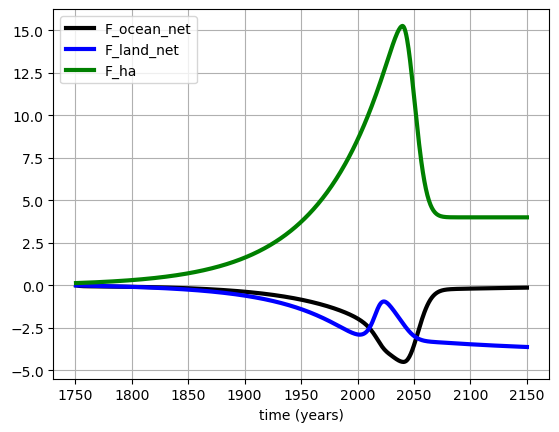

Max of T_anomaly =  3.5184186013741567 at time  2150.000000000028
Min of T_anomaly =  0.0 at time  1750.6677796327212


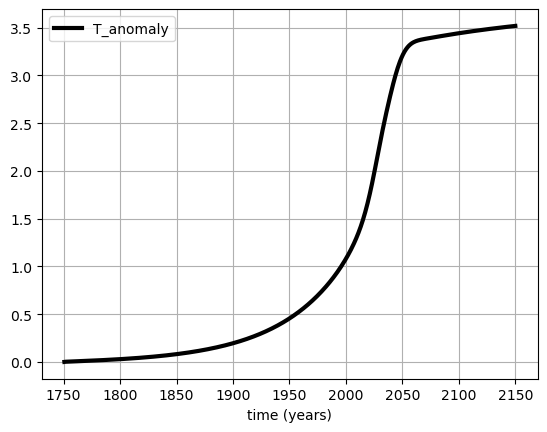

Max of albedo =  0.2999896768793822 at time  1750.6677796327212
Min of albedo =  0.29586846272215134 at time  2150.000000000028


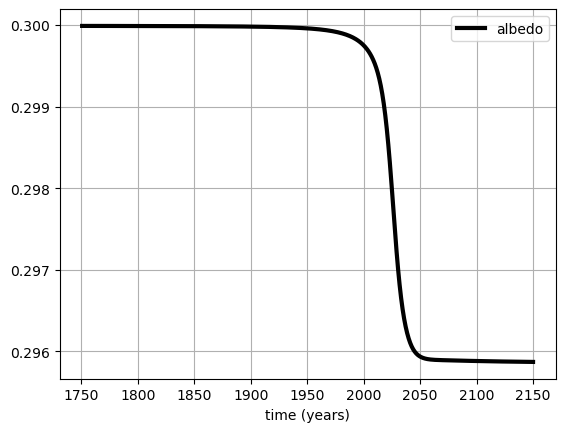

In [167]:
CS_Cambio_list = cl.run_Cambio(cl.PropagateClimateState_Cambio4, ClimateParams, time, eps)
items_to_plot = [['F_ocean_net','F_land_net','F_ha'],'T_anomaly','albedo']
cl.CS_list_plots(CS_Cambio_list,'',items_to_plot)

### Specialized plots
Here's looking at the excess carbon in the atmosphere and oceans in a log space, and other graphics

300
300


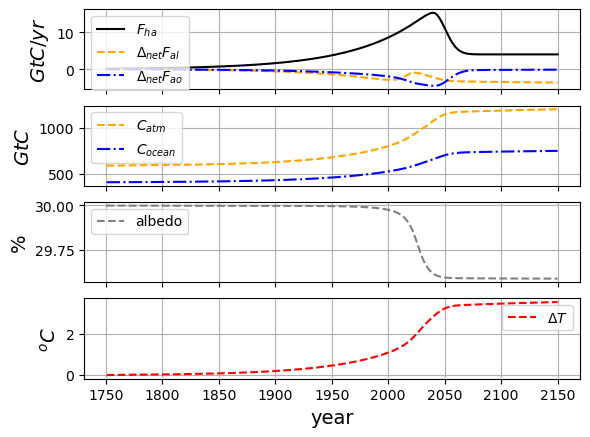

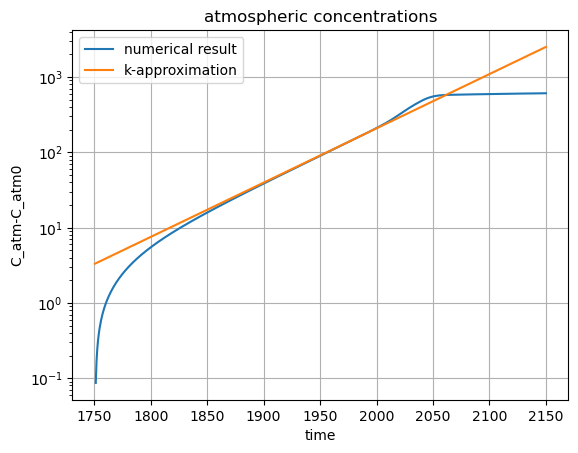

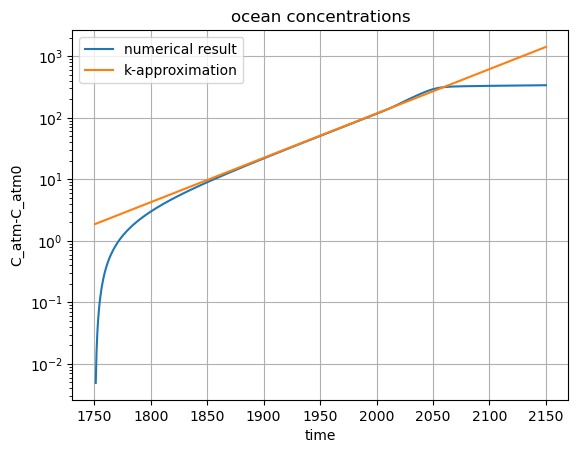

In [169]:
# Data
time_array = cl.CollectClimateTimeSeries(CS_Cambio_list,'time')
F_land_net_array = cl.CollectClimateTimeSeries(CS_Cambio_list,'F_land_net')
F_ocean_net_array = cl.CollectClimateTimeSeries(CS_Cambio_list,'F_ocean_net')
F_ha_array = cl.CollectClimateTimeSeries(CS_Cambio_list,'F_ha')
C_atm_array = cl.CollectClimateTimeSeries(CS_Cambio_list,'C_atm')
Delta_C_atm_array = C_atm_array[1:]-C_atm_array[0]
C_ocean_array = cl.CollectClimateTimeSeries(CS_Cambio_list,'C_ocean')
Delta_C_ocean_array = C_ocean_array[1:]-C_ocean_array[0]
T_anomaly_array = cl.CollectClimateTimeSeries(CS_Cambio_list,'T_anomaly')
albedo_array = cl.CollectClimateTimeSeries(CS_Cambio_list,'albedo')

# Comparing amounts to emission rate
fig, ax = plt.subplots(4, 1)

i=0
ax[i].plot(time_array,F_ha_array,color='k',linestyle='-',label='$F_{ha}$')
ax[i].plot(time_array,F_land_net_array,color='orange',linestyle='--',label='$\Delta_{net} F_{al}$')
ax[i].plot(time_array,F_ocean_net_array,color='blue',linestyle='-.',label='$\Delta_{net} F_{ao}$')
ax[i].grid('True')
ax[i].set_ylabel('$GtC/yr$',fontsize=fontsize)
ax[i].set_xticklabels([])
ax[i].legend(loc='upper left')

i=1
ax[i].plot(time_array,C_atm_array,color='orange',linestyle='--',label='$C_{atm}$')
ax[i].plot(time_array,C_ocean_array,color='blue',linestyle='-.',label='$C_{ocean}$')
ax[i].set_ylabel('$GtC$',fontsize=fontsize)
ax[i].grid('True')
ax[i].set_xticklabels([])
ax[i].legend()

i=2
# ax[i].plot(time_array,albedo_array,color='gray',linestyle='--',label='α')
ax[i].plot(time_array,albedo_array*100,color='gray',linestyle='--',label='albedo')
ax[i].set_ylabel('%',fontsize=fontsize)
ax[i].grid('True')
ax[i].set_xticklabels([])
ax[i].legend(loc='upper left')

i=3
ax[i].plot(time_array,T_anomaly_array,color='red',linestyle='--',label='$\Delta T$')
ax[i].set_ylabel('$^oC$',fontsize=fontsize)
ax[i].grid('True')
ax[i].legend()
ax[i].set_xlabel('year',fontsize=fontsize)

# Looking at the excess carbon in the atmosphere (log space)
plt.figure()
plt.title('atmospheric concentrations')
plt.semilogy(time_array[1:],Delta_C_atm_array,label='numerical result')
plt.grid('True')
plt.xlabel('time')
plt.ylabel('C_atm-C_atm0')
imid = round(len(time_array)/2); print(imid)
y_usingk = np.log(Delta_C_atm_array[imid]) + k*(time_array-time_array[imid])
plt.semilogy(time_array,np.exp(y_usingk),label='k-approximation')
plt.legend()

# Looking at the excess carbon in the ocean (log space)
plt.figure()
plt.title('ocean concentrations')
plt.semilogy(time_array[1:],Delta_C_ocean_array,label='numerical result')
plt.grid('True')
plt.xlabel('time')
plt.ylabel('C_atm-C_atm0')
imid = round(len(time_array)/2); print(imid)
y_usingk = np.log(Delta_C_ocean_array[imid]) + k*(time_array-time_array[imid])
plt.semilogy(time_array,np.exp(y_usingk),label='k-approximation')
plt.legend()

### Looking at the ratio of net ocean sequestration to net land sequestration

r (predicted) = 0.6666666666666666
r (observed) = 0.6004573199348472


Text(0, 0.5, 'r')

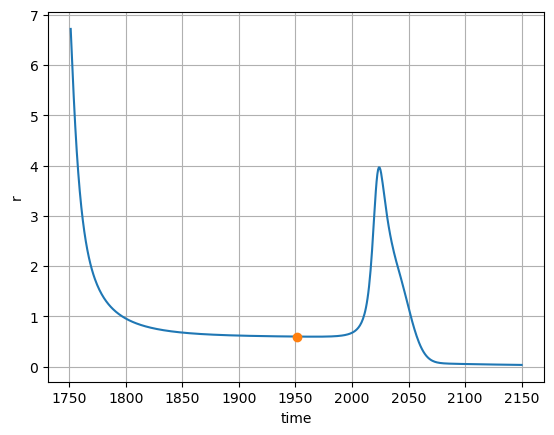

In [171]:
# Calculating the ratio "r"
F_land_net = cl.CollectClimateTimeSeries(CS_Cambio_list,'F_land_net')
F_ocean_net = cl.CollectClimateTimeSeries(CS_Cambio_list,'F_ocean_net')
r_numerical = F_ocean_net / F_land_net
print('r (predicted) =', r)
print('r (observed) =', r_numerical[imid])

plt.figure()
plt.plot(time_array[1:],r_numerical[1:])
plt.plot(time_array[imid],r_numerical[imid],'o')
plt.grid('True')
plt.xlabel('time')
plt.ylabel('r')

### Analysis of the ocean carbon reservoir
Is 443 GtC pre-industrial, or 575 GtC in year 2003, reasonable?

The NASA figure indicates the region of "air-sea gas exchange" contains $1000 \ GtC$. Carroll et al, 2022 Fig. 9, find a total DIC of 880 GtC in the top 100 meters alone.

By contrast, the total amount of DIC is much bigger, more like 37,000 GtC (according to NASA and other sources). Of that DIC, at a pH of 8, only about 2% of DIC is in the form $CO_2(aq)$, as shown by the table in https://www.aqion.de/site/153. So, our figure of 575 in year 2003 GtC is fairly close to the $CO_2(aq)$ portion to a depth of 1500 m (or so), 2% of 37,000, or 750 GtC. Hence, our kinetic scheme would be more accurately written

$$
F_{oa} = k_{oa}[C_{ocean, CO_2(aq)}] = k_{oa}f_{CO_2}[C_{ocean, DIC}] = k_{oa}'[C_{ocean, DIC}]
$$

where we're defining $f_{CO_2} \equiv [C_{ocean, CO_2(aq)}]/[C_{ocean}] \approx 2\%$.

An approximation would be to claim that that equilibrium is so fast, and the DIC amount is so big, that $[C_{ocean, CO_2(aq)}] \approx constant$. However, that doesn't work -- there has to be depletion of $[C_{ocean, DIC}]$. 

### Getting $\Delta z$, the depth of the mixed layer
The idea here is to calculate $\Delta z$, the geometric thickness of the "mixed layer" of the ocean relevant to ocean/atmosphere exchange of $CO_2$. To do that, we begin with Henry's law, which says 

$$
P_{atm} y_{CO_2}=Hx_{CO_2}
$$

where $y_{CO_2}$ is the mole fraction of $CO_2$ in the air, $x_{CO_2}$ is the mole fraction of $CO_2$ in water, and $H$ is Henry's constant for $CO_2$ in aqueous solution. We should note the caveat that it's not clear how the aqueous chemistry of dissolved $CO_2$ figures in here, but for now we'll just say the derivative species -- carbonate and bicarbonate -- are not included in $x_{CO_2}$. 

With that caveat, the mole fraction of $CO_2$ in water is given by

$$
x_{CO_2} = Py_{CO_2}/H
$$

Next, we assemble the following additional equations (all approximations). First, the area of the oceans (assuming $2/3$ coverage) is given by 

$$
A_{oceans} = 4 \pi r^2 \times {2 \over 3} \ \ \ (1)
$$

We can express the mass of water in the oceans within our ocean's $\Delta z$ as

$$
m_{H_2O} = A_{oceans} \Delta z \times \rho_{H_2O}
$$

The moles of water within that layer is 

$$
n_{H_2O} = {m_{H_2O} \over M_{H_2O}}
$$

where $M_{H_2O}$ is the molar mass of water. Assuming seawater is sufficiently dilute, the mole fraction of $CO_2$ in water can be approximated as  

$$
x_{CO_2} = {n_{CO_2} \over n_{H_2O}}
$$

where the moles of $CO_2$ can be related to the mass of $CO_2$ using $M_{CO_2}$, the molar mass of $CO_2$, according to  

$$
n_{CO_2} = {m_{CO_2} \over M_{CO_2}}
$$

Solving these equations for $\Delta z$, we get

$$
\Delta z = {m_{CO_2} \over A_{oceans} \times \rho_{H_2O} \times x_{CO_2}} {M_{H_2O} \over M_{CO_2}}
$$

Values we can use are the molar masses
- $M_{CO_2}=44 \ g/mol$
- $M_{H_2O}=18 \ g/mol$
- $y_{CO_2}=290 \ ppm = 290 \times 10^{-6}$ (pre-industrial value)
- $H = 1670 \ atm$ 

where the last value is obtained from https://www.vedantu.com/question-answer/henrys-law-constant-for-co2-in-water-is-167times-class-12-chemistry-cbse-5f5669d16791b91adfa23385. Also: https://henrys-law.org/henry/casrn/124-38-9.

Temperature dependence reference for H: https://henrys-law.org/henry/casrn/124-38-9.

In [174]:
P_atm = AssignQuantity(1,'atm')
Henry = AssignQuantity(1670,'atm')
y = AssignQuantity(290e-6,'dimensionless')
x_CO2 = y*P_atm/Henry; print('x_CO2 =',x_CO2)
radius_of_Earth = AssignQuantity(6400,'km')
Area_of_oceans = 4*np.pi*radius_of_Earth**2 * (2/3)
density_of_seawater = AssignQuantity(1,'g/cm^3')
M_H2O = AssignQuantity(18,'g/mol')
M_CO2 = AssignQuantity(44,'g/mol')
m_CO2 = AssignQuantity(C_ocean_preind*1e15,'gram')
delta_z = m_CO2*M_H2O/M_CO2/(Area_of_oceans*density_of_seawater*x_CO2)
delta_z.ito('km')
print('Geometrical thickness of the aqueous CO2 reservoir =', delta_z)
delta_z_CO2aq = delta_z
delta_z_DIC = delta_z * 0.02
delta_z_DIC.ito('m')
print('Geometrical thickness of the DIC reservoir =', delta_z_DIC)

# The lines below are double-checking the analysis above (especially values of Henry's constant, which
# is published in many different units)

# See also https://webbook.nist.gov/cgi/cbook.cgi?ID=C124389&Mask=10

K_H = AssignQuantity(0.032,'mol/L/atm'); print(K_H)
P_CO2 = y*AssignQuantity(1,'atm'); print(P_CO2)
C_CO2_aq = K_H*P_CO2; print(C_CO2_aq)
x_CO2 = C_CO2_aq/AssignQuantity(55.5,'mol/L');print(x_CO2)

K_H = AssignQuantity(0.034,'mol/L/bar')
K_H.ito('mol/L/atm'); print(K_H)

x_CO2 = 1.7365269461077844e-07 dimensionless
Geometrical thickness of the aqueous CO2 reservoir = 2.8201904145085352 kilometer
Geometrical thickness of the DIC reservoir = 56.40380829017071 meter
0.032 mole / liter / standard_atmosphere
0.00029 standard_atmosphere
9.280000000000001e-06 mole / liter
1.6720720720720721e-07 dimensionless
0.0344505 mole / liter / standard_atmosphere


### Messing around with conversions of carbon amounts
See (https://acp.copernicus.org/articles/13/2793/2013/acp-13-2793-2013-supplement.pdf)

In [176]:
GtC_over_ppm = 2.123
print('Pre-industrial atmospheric carbon in GtC:')
print(290*GtC_over_ppm)

GtCO2_over_GtC = 44/12
GtC_over_GtCO2 = 1/GtCO2_over_GtC
print(GtC_over_ppm, GtCO2_over_GtC, GtC_over_GtCO2)

C_atm_2024_ppm = 424
C_atm_2024_GtC = C_atm_2024_ppm*GtC_over_ppm; print('Current mass of C =', C_atm_2024_GtC, 'GtC')
C_atm_2024_GtCO2 = C_atm_2024_GtC*GtCO2_over_GtC; print('Current mass of CO2 =', C_atm_2024_GtCO2, 'GtCO2')

# The NASA figure says 800 GtC
C_atm_NASA_GtC = 800
C_atm_NASA_ppm = C_atm_NASA_GtC/GtC_over_ppm
print('NASA figure ... ', C_atm_NASA_ppm, C_atm_NASA_GtC)

# Based on https://gml.noaa.gov/ccgg/trends/graph.html (January values at Mauna Loa)
print('Start of the year')
C_atm_2005_ppm = 379.10; print(C_atm_2005_ppm, C_atm_2005_ppm*GtC_over_ppm)
C_atm_2004_ppm = 377.19; print(C_atm_2004_ppm, C_atm_2004_ppm*GtC_over_ppm)
C_atm_2003_ppm = 374.90; print(C_atm_2003_ppm, C_atm_2003_ppm*GtC_over_ppm)

Pre-industrial atmospheric carbon in GtC:
615.6700000000001
2.123 3.6666666666666665 0.27272727272727276
Current mass of C = 900.152 GtC
Current mass of CO2 = 3300.557333333333 GtCO2
NASA figure ...  376.8252472915685 800
Start of the year
379.1 804.8293000000001
377.19 800.7743700000001
374.9 795.9127000000001


### Data from from Dorgeist et al, 2024
Using this figure from Dorgeist et al, 2024, *A consistent budgeting of terrestrial
carbon fluxes*:
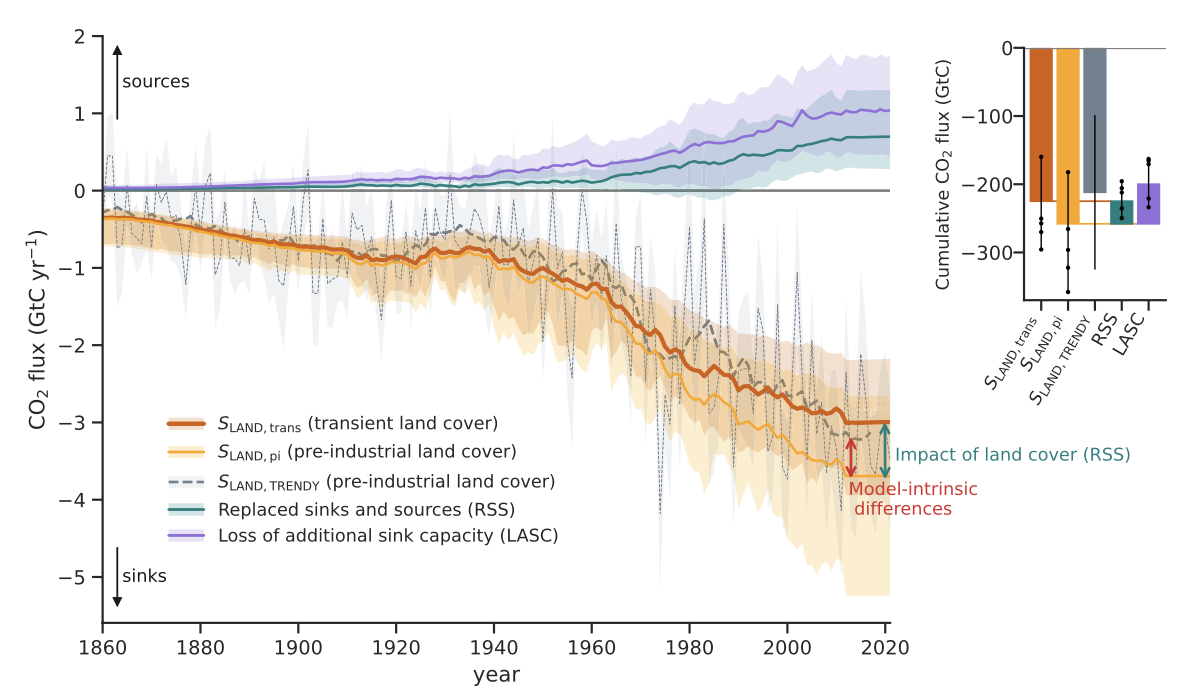

### World population and carbon emissions
These population data come from https://www.worldometers.info/world-population/world-population-by-year/. It's not very exponential overall, but the best fit yields a growth rate from 1950 to present of about $1.64\% yr^{-1}$. By comparison, the emissions data presented above here have been about $1.65\% yr^{-1}$.

Qualitatively, after 1950 human emissions have tracked population very closely. Analysis:

$$
\epsilon = \bar \epsilon \times P
$$

so $\bar \epsilon$ has dimensions emissions/person. Units should be tons C/person/year. To convert to tons CO2/person/year, multiply by 3.67.

The result displayed below show that the per-capita emissions in the first half of the 20th century were 4.2 tCO2/year. Post 1950, that rose to 5.2 tCO2/year.

k based on our world in data = 0.013987139901477263
intercept based on our world in data = 0.013987139901477263
k based on our world in data = 0.01641245649006673
intercept based on our world in data = 0.01641245649006673
5.2
4.2
per-capita emissions 1900-1950 =  4.2204999999999995 tons CO2/person/year
per-capita emissions post 1950 =  5.211399999999999 tons CO2/person/year


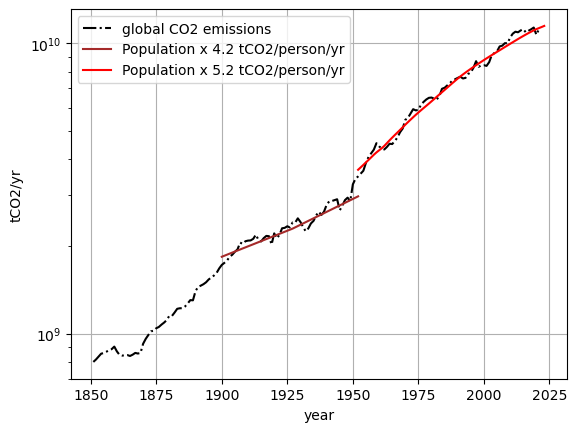

In [193]:
my_data = genfromtxt('World population.csv', delimiter=',')

# Use all the data
istop = 2
wp_time = my_data[1:-istop,0]
wp_population = my_data[1:-istop,1]

# Fitting
logwp_population = np.log(wp_population)
popt, pcov = curve_fit(linfun, wp_time, logwp_population)
k_wp_population = popt[0]
intercept_logwp_population = popt[1]
print('k based on our world in data =', k_wp_population)
print('intercept based on our world in data =', k_wp_population)
logwp_population_bestfit = intercept_logwp_population + k_wp_population*wp_time

# Use data since 1950
istop = 5
wp_time_short = my_data[1:-istop,0]
wp_population_short = my_data[1:-istop,1]

# Fitting
logwp_population_short = np.log(wp_population_short)
popt, pcov = curve_fit(linfun, wp_time_short, logwp_population_short)
k_wp_population_short = popt[0]
intercept_logwp_population_short = popt[1]
print('k based on our world in data =', k_wp_population_short)
print('intercept based on our world in data =', k_wp_population_short)
logwp_population_bestfit = intercept_logwp_population_short + k_wp_population*wp_time_short

plt.figure()
epsbar1 = 1.42
epsbar2 = 1.15

epsbar1_CO2 = epsbar1*3.67; epsbar1_CO2_str = f"{epsbar1_CO2:.1f}"; print(epsbar1_CO2_str)
epsbar2_CO2 = epsbar2*3.67; epsbar2_CO2_str = f"{epsbar2_CO2:.1f}"; print(epsbar2_CO2_str)

plt.semilogy(time_ourworldindata,eps_ourworldindata,'k-.',label='global CO2 emissions')
plt.semilogy(wp_time[-4:-1],wp_population[-4:-1]*epsbar2,'brown', label='Population x '+epsbar2_CO2_str+' tCO2/person/yr')
plt.semilogy(wp_time[:-3],  wp_population[:-3]*epsbar1,  'red',   label='Population x '+epsbar1_CO2_str+' tCO2/person/yr')
plt.grid(True)
plt.xlabel('year')
plt.ylabel('tCO2/yr')
plt.legend()

print('per-capita emissions 1900-1950 = ', epsbar2_CO2, 'tons CO2/person/year')
print('per-capita emissions post 1950 = ', epsbar1_CO2, 'tons CO2/person/year')

### Checking that net flux results are insensitive to the choice of $k_{la}=120$ GtC/yr.

Max of Cambio4 with new k_la (F_ocean_net) =  0.0 at time  1750.6677796327212
Min of Cambio4 with new k_la (F_ocean_net) =  -4.498095630444212 at time  2040.4841402337433
Max of Cambio4 with new k_la (F_land_net) =  0.000325973879000685 at time  1750.6677796327212
Min of Cambio4 with new k_la (F_land_net) =  -3.62244979101888 at time  2150.000000000028
Max of Cambio4 with new k_la (F_ha) =  15.252233588429393 at time  2039.816360601022
Min of Cambio4 with new k_la (F_ha) =  0.13649186260348795 at time  1750.6677796327212


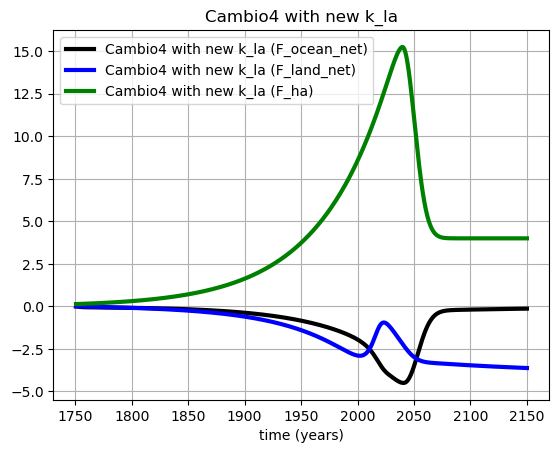

Max of Cambio4 with new k_la (T_anomaly) =  3.5169409135850596 at time  2150.000000000028
Min of Cambio4 with new k_la (T_anomaly) =  0.0 at time  1750.6677796327212


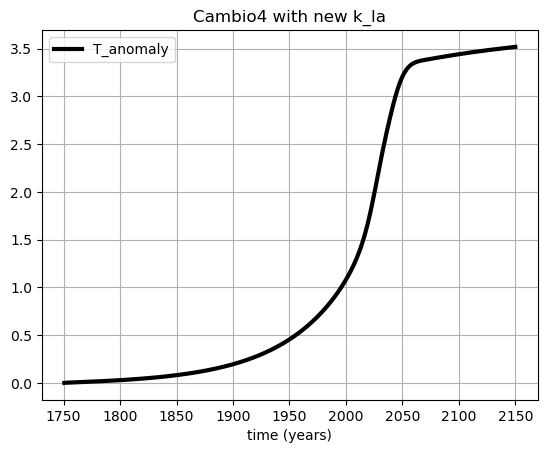

Max of Cambio4 with new k_la (albedo) =  0.2999896768793822 at time  1750.6677796327212
Min of Cambio4 with new k_la (albedo) =  0.2958686536611643 at time  2150.000000000028


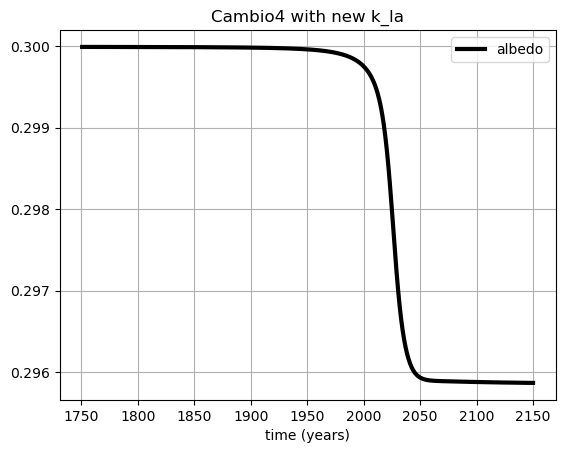

Max of Cambio4 with new k_la (C_atm) =  1198.1484989803062 at time  2150.000000000028
Min of Cambio4 with new k_la (C_atm) =  590.091364164596 at time  1750.6677796327212


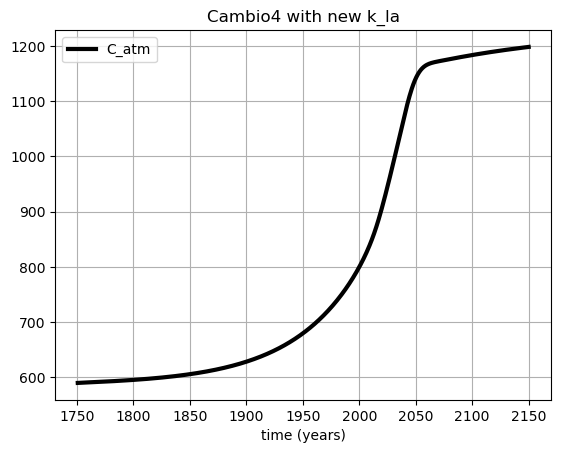

In [196]:
ClimateParams = cl.CreateClimateParams(epsdictionary,k_la=150)
ClimateState_Cambio_list_newk_la = cl.run_Cambio(cl.PropagateClimateState_Cambio4, ClimateParams, time, eps)
items_to_plot = [['F_ocean_net','F_land_net','F_ha'],'T_anomaly','albedo','C_atm']
cl.CS_list_plots(ClimateState_Cambio_list_newk_la,'Cambio4 with new k_la',items_to_plot)

N =  0.13498718612196003


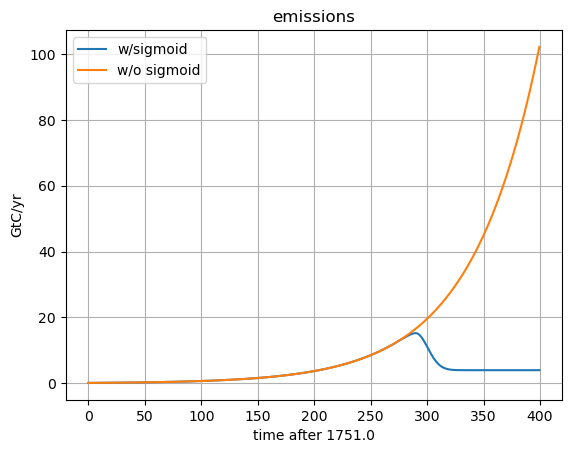

In [198]:
# Getting the Cambio1 results for the analytical comparison
ClimateState_Cambio1_list = cl.run_Cambio(cl.PropagateClimateState_Cambio1, ClimateParams, time, eps)
# items_to_plot = [['F_ocean_net','F_land_net','F_ha'],'T_anomaly','albedo']
# cl.Climatestate_list_plots(ClimateState_Cambio_list,items_to_plot,'Cambio4')

# time array
time_array = cl.CollectClimateTimeSeries(ClimateState_Cambio1_list,'time')
t_array = time_array-time_array[0]

# Looking at the excess carbon in the atmosphere
C_atm_array = cl.CollectClimateTimeSeries(ClimateState_Cambio1_list,'C_atm')
Delta_C_atm_array = C_atm_array[1:]-C_atm_array[0]

# Looking at the excess carbon in the oceans
C_ocean_array = cl.CollectClimateTimeSeries(ClimateState_Cambio1_list,'C_ocean')
Delta_C_ocean_array = C_ocean_array[1:]-C_ocean_array[0]

# Making sure that Ne^kt is a good approximation to the scenario emission
N = eps[0]; print('N = ',  N)
eps_exponential = N*np.exp(k*t_array)
plt.figure()
plt.plot(t_array,eps[:-1], label='w/sigmoid')
plt.plot(t_array,eps_exponential, label='w/o sigmoid')
plt.grid(True)
plt.xlabel('time after '+str(np.round(time_array[0])))
plt.ylabel('GtC/yr')
plt.title('emissions')
plt.legend()

In [200]:
# Lining up times for fitting
t_array_analytical = t_array[1:]
maxifit = round(len(time_array)/2)
ifit = np.arange(1,maxifit)
t_array_fit = t_array[ifit]
t_array_numerical = t_array[:-1]
Delta_C_atm_array_fit = Delta_C_atm_array[ifit]
Delta_C_ocean_array_fit = Delta_C_ocean_array[ifit]
linewidth = 5

### Trying out the ocean/atmosphere form
This form mimics the analytical result for the ocean/atmosphere only system, but with adjustable parameters $C_1$ and $C_2$:

$$
\Delta C_{atm} = C_{1,atm} + C_{2,atm}e^{kt}
$$

$$
\Delta C_{ocean} = C_{1,ocean} + C_{2,atm}e^{kt}
$$

### Data
See https://www.sealevel.info/co2.html


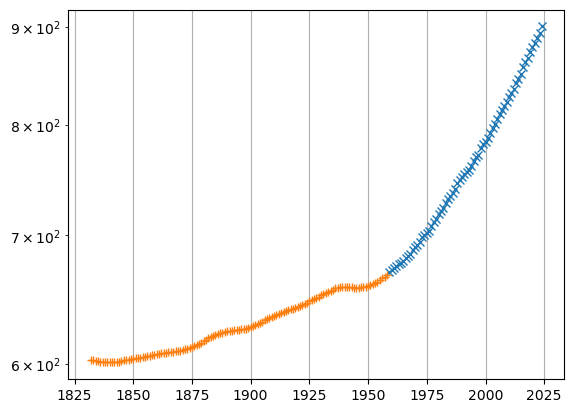

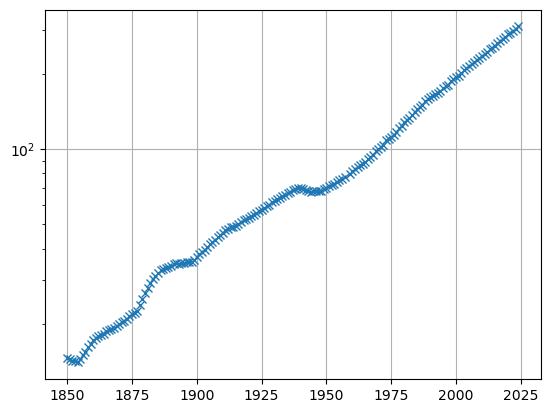

In [211]:
CO2_preind = 590

ds1 = np.loadtxt('CO2_1958_2024.txt')
ds1_time = ds1[:,0]
ds1_CO2 = ds1[:,1]*2.12

ds2 = np.loadtxt('CO2_1850_1957.txt')
ds2_time = ds2[:,0]
ds2_CO2 = ds2[:,1]*2.12

ds3 = np.loadtxt('CO2_1832_1978.txt')
ds3_time = ds3[:,0]
ds3_CO2 = ds3[:,1]*2.12
ids3_last = -20
ids3_first = 0
ds3_time = ds3_time[ids3_first:ids3_last]
ds3_CO2 = ds3_CO2[ids3_first:ids3_last]

plt.figure()
plt.semilogy(ds1_time,ds1_CO2,'x')
# plt.semilogy(ds2_time,ds2_CO2,'o')
plt.semilogy(ds3_time,ds3_CO2,'+')
plt.grid('True')

obs_time = np.array([*ds2_time,*ds1_time])
obs_CO2 = np.array([*ds2_CO2,*ds1_CO2])
Delta_obs_CO2 = obs_CO2 - CO2_preind

# obs_time = np.array(ds1_time)
# obs_CO2 = np.array(ds1_CO2)
# Delta_obs_CO2 = obs_CO2 - CO2_preind

plt.figure()
plt.semilogy(obs_time,Delta_obs_CO2,'x')
plt.grid('True')


### The exponential form
Looking for an approximate solution to Cambio1.0. We define 

$$
\Delta C_{atm}(t) = C_{atm}(t) - C_{atm,preind} \ \ \ (E1)
$$

$$
\Delta C_{ocean}(t) = C_{ocean}(t) - C_{ocean,preind} \ \ \ (E2)
$$

We'll let anthropogenic emissions begin in the year $1750$, i.e., $t = t_{calendar}-1750$ (so $t=0$ in the year $1750$). We'll assume exponential growth of anthropogenic emissions,

$$
\epsilon(t) = N e^{kt} \ \ \ (E3)
$$

where we set $N$ and $k$ such that $\epsilon(t)$ matches observations: $\epsilon(2003-1750)  = 9 {GtC \over yr}$ and $k=0.0166 \ yr^{-1}$. Our equations of motion are

$$
{d \Delta C_{atm} \over dt} = {d C_{atm} \over dt} = \epsilon(t) + k_{la} + k_{oa} C_{ocean} - k_{ao} C_{atm} - k_{al0} -  k_{al1} C_{atm} \ \ \ (E4)
$$

$$
{d \Delta C_{ocean} \over dt} = {d C_{ocean} \over dt} = k_{ao}C_{atm} - k_{oa} C_{ocean} \ \ \ (E5)
$$

We also impose the condition that the atmosphere and oceans were in steady-state prior to the start of anthropogenic emissions, which means that

$$
{d \Delta C_{atm} \over dt}(t=0) = {d C_{atm} \over dt}(t=0) = \epsilon(0) = N \ \ \ (E6)
$$

$$
{d \Delta C_{atm} \over dt}(t=0) = {d C_{atm} \over dt}(t=0) = 0 \ \ \ (E7)
$$

(although we won't use E7). Our empirical formulas are 

$$
\Delta C_{atm} \approx A_{atm}e^{kt}(1-e^{-k_{atm}t}) \ \ \ (E8)
$$

$$
\Delta C_{ocean} \approx A_{ocean}e^{kt}(1-e^{-k_{ocean}t}) \ \ \ (E9)
$$

We estimate our four parameters ($A_{atm}$, $A_{ocean}$, $k_{atm}$, $k_{ocean}$) as follows: 

- By the time we get to year $2003$, we assume the transient term in E8 ($e^{-k_{atm}t}$) is negligibly small. In combination with the known excess amount of carbon in the atmosphere in the year $2003$ ($\Delta C_{atm,2003}=800-615=185 \ GtC$), this yields 

$$
A_{atm} \approx {\Delta C_{atm,2003} \over e^{kt}}
$$

- The 1st derivative of Eq. E8, in combination with the condition that the atmosphere was in steady state at $t=0$, yields

$$
k_{atm} \approx {N \over A_{atm}}
$$

- For $A_{ocean}$, it's the same method we used for $A_{atm}$:

$$
A_{ocean} \approx {\Delta C_{ocean,2003} \over e^{kt}}
$$

This procedure requires that we know $C_{ocean,preind}$ and $C_{ocean,2003}$, which is described in a previous cell. 

- I haven't been able to derive a good way of predicting $k_{ocean}$. Empirically, the best-fit results show that $k_{ocean}$ is pretty close to $k_{atm}$, so that's how it's coded up below:

$$
k_{ocean} \approx k_{atm}
$$

In [214]:
# The proposed function for Delta C_atm (also C_ocean)
### This picks up the global variable "k" ###
def func_Delta_C_analytical(t_array,A_coef,k_value):
    return A_coef*np.exp(k*t_array)*(1-np.exp(-k_value*t_array))

t 253.0
Delta_C_atm_2003 190
F_oa 2003 90
C_ocean_2003_guess 531.2708118907792
A_coef_ocean_guess 1.8070573778040162
Atmosphere ...
  A-coefficient:
   Guess =  2.8497294847969337
   Best-fit =  3.2342296176750622
  k-value:
   Guess =  0.04736842105263159
   Best-fit =  0.0264960239952464
Ocean ...
  A-coefficient:
   Guess =  1.8070573778040162
   Best-fit =  2.056620889285782
  k-value:
   Guess =  0.04736842105263159
   Best-fit =  0.024865903206063363
  Ratios (based on best fit):
   A_coef_ocean/A_coef_atm =  0.6358920461448843
   k_transient_ocean/k_transient_atm =  0.9384767771392608
   k_oa/k_ao =  0.6962523460676878


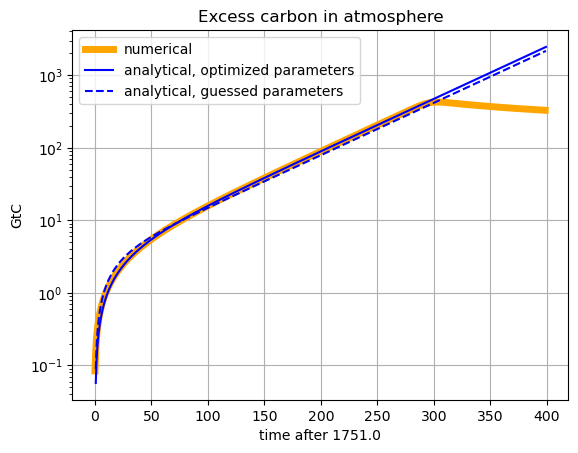

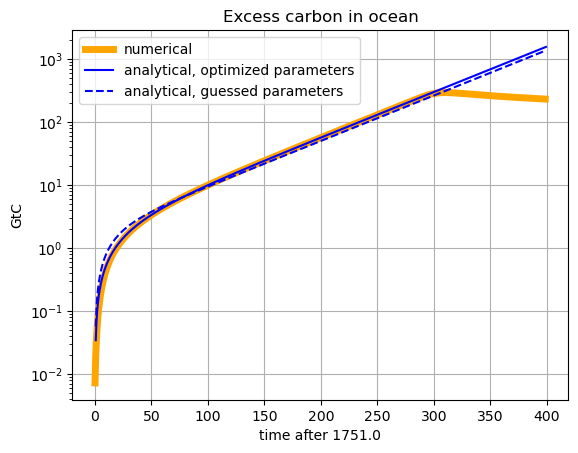

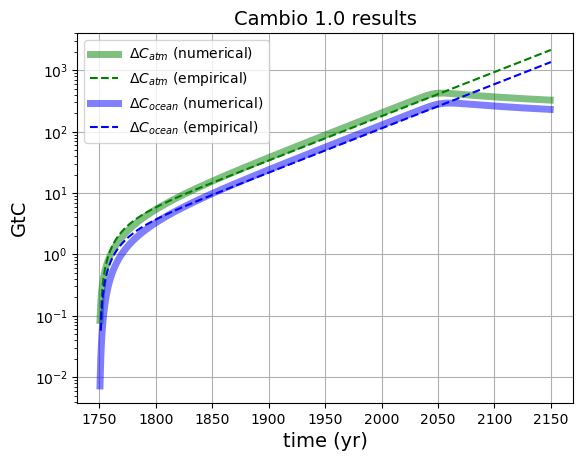

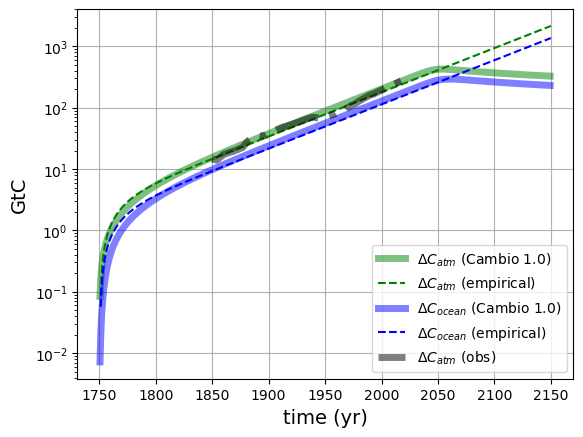

In [216]:
# Get the climate parameters and the preindustrial climate state
ClimateParams = cl.CreateClimateParams(epsdictionary)
Preind_ClimateState = cl.CreateClimateState(ClimateParams)


# We'll need the time of our reference 
t = 2003-Preind_ClimateState['time']; print('t',t)

# Initial guesses for the A-coefs and k-values (atm)
Delta_C_atm_2003 = ClimateParams['C_atm 2003']-ClimateParams['preindustrial C_atm']; print('Delta_C_atm_2003',Delta_C_atm_2003)
A_coef_atm_guess = Delta_C_atm_2003/np.exp(k*t)
k_transient_atm_guess = N/A_coef_atm_guess

# Initial guesses for the A-coefs and k-values (ocean)
print('F_oa 2003',ClimateParams['F_oa 2003'])
C_ocean_2003_guess = ClimateParams['F_oa 2003']/ClimateParams['k_oa']; print('C_ocean_2003_guess',C_ocean_2003_guess)
Delta_C_ocean_2003 = C_ocean_2003_guess - Preind_ClimateState['C_ocean']
A_coef_ocean_guess = Delta_C_ocean_2003/np.exp(k*t); print('A_coef_ocean_guess',A_coef_ocean_guess)
k_transient_ocean_guess = k_transient_atm_guess

# Doing the fit
A_coef_atm,k_transient_atm = optimize.curve_fit(\
    func_Delta_C_analytical, xdata = t_array_fit, \
        ydata = Delta_C_atm_array_fit, p0=[A_coef_atm_guess,k_transient_atm_guess])[0]

# Let's see how we did
Delta_C_atm_analytical = func_Delta_C_analytical(t_array_analytical,A_coef_atm,k_transient_atm)
Delta_C_atm_analytical_guess = func_Delta_C_analytical(t_array_analytical,A_coef_atm_guess,k_transient_atm_guess)
Delta_C_atm_analytical_guess_fit = func_Delta_C_analytical(t_array_fit,A_coef_atm_guess,k_transient_atm_guess)
plt.figure()
plt.semilogy(t_array_numerical,Delta_C_atm_array,color='orange',label='numerical',linewidth=linewidth)
plt.semilogy(t_array_analytical,Delta_C_atm_analytical,color='blue',label='analytical, optimized parameters')
plt.semilogy(t_array_analytical,Delta_C_atm_analytical_guess,color='blue',linestyle='--',label='analytical, guessed parameters')
plt.semilogy()
plt.grid(True)
plt.xlabel('time after '+str(np.round(time_array[0])))
plt.ylabel('GtC')
plt.title('Excess carbon in atmosphere')
plt.legend()

# Report
print('Atmosphere ...')

print('  A-coefficient:')
print('   Guess = ', A_coef_atm_guess)
print('   Best-fit = ', A_coef_atm)

print('  k-value:')
print('   Guess = ', k_transient_atm_guess)
print('   Best-fit = ', k_transient_atm)

# For the ocean ...

# Doing the fit
A_coef_ocean,k_transient_ocean = optimize.curve_fit(\
    func_Delta_C_analytical, xdata = t_array_fit, \
        ydata = Delta_C_ocean_array_fit,p0=[A_coef_ocean_guess,k_transient_ocean_guess])[0]

# Let's see how we did
Delta_C_ocean_analytical = func_Delta_C_analytical(t_array_analytical,A_coef_ocean,k_transient_ocean)
Delta_C_ocean_analytical_guess = func_Delta_C_analytical(t_array_analytical,A_coef_ocean_guess,k_transient_ocean_guess)
plt.figure()
plt.semilogy(t_array_numerical,Delta_C_ocean_array,color='orange',label='numerical',linewidth=linewidth)
plt.semilogy(t_array_analytical,Delta_C_ocean_analytical,color='blue',label='analytical, optimized parameters')
plt.semilogy(t_array_analytical,Delta_C_ocean_analytical_guess,color='blue',linestyle='--',label='analytical, guessed parameters')
plt.semilogy()
plt.grid(True)
plt.xlabel('time after '+str(np.round(time_array[0])))
plt.ylabel('GtC')
plt.title('Excess carbon in ocean')
plt.legend()

# Plotting both
plt.figure()
ta0 = time_array[0]
plt.semilogy(t_array_numerical+ta0,Delta_C_atm_array,color='green',alpha=0.5,label='$\Delta C_{atm}$ (numerical)',linewidth=linewidth)
plt.semilogy(t_array_analytical+ta0,Delta_C_atm_analytical_guess,color='green',linestyle='--',label='$\Delta C_{atm}$ (empirical)')
plt.semilogy(t_array_numerical+ta0,Delta_C_ocean_array,color='blue',alpha=0.5,label='$\Delta C_{ocean}$ (numerical)',linewidth=linewidth)
plt.semilogy(t_array_analytical+ta0,Delta_C_ocean_analytical_guess,color='blue',linestyle='--',label='$\Delta C_{ocean}$ (empirical)')
plt.grid(True)
plt.xlabel('time (yr)',fontsize=fontsize)
plt.ylabel('GtC',fontsize=fontsize)
plt.title('Cambio 1.0 results',fontsize=fontsize)
plt.legend()

# Plotting both with observations
plt.figure()
ta0 = time_array[0]
plt.semilogy(t_array_numerical+ta0,Delta_C_atm_array,color='green',alpha=0.5,label='$\Delta C_{atm}$ (Cambio 1.0)',linewidth=linewidth)
plt.semilogy(t_array_analytical+ta0,Delta_C_atm_analytical_guess,color='green',linestyle='--',label='$\Delta C_{atm}$ (empirical)')
plt.semilogy(t_array_numerical+ta0,Delta_C_ocean_array,color='blue',alpha=0.5,label='$\Delta C_{ocean}$ (Cambio 1.0)',linewidth=linewidth)
plt.semilogy(t_array_analytical+ta0,Delta_C_ocean_analytical_guess,color='blue',linestyle='--',label='$\Delta C_{ocean}$ (empirical)')
plt.semilogy(obs_time,Delta_obs_CO2,color='black',alpha=0.5,linestyle='-.',label='$\Delta C_{atm}$ (obs)',linewidth=linewidth)
plt.grid(True)
plt.xlabel('time (yr)',fontsize=fontsize)
plt.ylabel('GtC',fontsize=fontsize)
plt.legend()



# Report
print('Ocean ...')
print('  A-coefficient:')
print('   Guess = ', A_coef_ocean_guess)
print('   Best-fit = ', A_coef_ocean)

print('  k-value:')
print('   Guess = ', k_transient_ocean_guess)
print('   Best-fit = ', k_transient_ocean)

print('  Ratios (based on best fit):')
print('   A_coef_ocean/A_coef_atm = ', A_coef_ocean/A_coef_atm)
print('   k_transient_ocean/k_transient_atm = ', k_transient_ocean/k_transient_atm)
print('   k_oa/k_ao = ', k_ao/k_oa)

### Filippo's solution

This is based on theory developed by Filippo Posta (see https://colab.research.google.com/drive/11fWFf96WUvMGx9X5jWN9v6LaGo10YY0Q#scrollTo=qDUda2SyrUn5):

$$
C_a = c_1 \nu_{1,a} e^{\lambda_1 t} + c_2 \nu_{2,a} e^{\lambda_2 t} + N_a e^{kt} + A_a
$$

and

$$
C_o = c_1 \nu_{1,o} e^{\lambda_1 t} + c_2 \nu_{2,o} e^{\lambda_2 t} + N_o e^{kt} + A_o
$$

A modification is that we cast the problem in terms of the *excess* carbon in the atmosphere and oceans ($\Delta C_a$ and $\Delta C_a$), which means we ignore the terms $A_a$ and $A_o$ in that formulation. That is, we define the functions

$$
\Delta C_a = c_1 \nu_{1,a} e^{\lambda_1 t} + c_2 \nu_{2,a} e^{\lambda_2 t} + N_a e^{kt} \ \ \ (F1)
$$

and

$$
\Delta C_o = c_1 \nu_{1,o} e^{\lambda_1 t} + c_2 \nu_{2,o} e^{\lambda_2 t} + N_o e^{kt} \ \ \ (F2)
$$

Filippo's formalism does not specify values of $c_1$ or $c_2$, so in the cell below we find optimal values that match the numerical results.

In [219]:
# Getting the constants we have formulas for

# N_a and N_o
N_denom = (k+k_ao+k_al1)*(k+k_oa)-k_oa*k_ao
N_a = N*(k+k_oa)/N_denom
N_o = k_ao*N/N_denom
print('N_a ', N_a)
print('  Comparable to A_coef_atm ', A_coef_atm)
print('N_o ', N_o)
print('  Comparable to A_coef_ocean', A_coef_ocean)

# lambda1 and lambda2
discriminant = (k_oa+k_ao-k_al1)**2+4*k_ao*k_oa
lambda1 = (k_al1-k_oa-k_ao+discriminant**.5)/2
lambda2 = (k_al1-k_oa-k_ao-discriminant**.5)/2
print('')
print('lambdas ', lambda1, lambda2)
print('  k-k_transient_atm ',k-k_transient_atm)
print('  k-k_transient_ocean ', k-k_transient_ocean)

# The nu-values
nu1_a = (k_oa+lambda1)/k_ao; print('nu1_a',nu1_a)
nu2_a = (k_oa+lambda2)/k_ao; print('nu2_a',nu2_a)
nu1_o = 1
nu2_o = 1

# The A-values
A_a = k_la/k_al1
A_o = A_a*k_ao/k_oa
print('')
print('A-values ', A_a, A_o)
print('  Comparable to C_atm_preind ', C_atm_preind)
print('  Comparable to C_ocean_preind ', C_ocean_preind)

# Don't need this, but calculating it anyway
k_al = k_la-k_al0
print('')
print('k_al ', k_al)

N_a  3.1453967823365723
  Comparable to A_coef_atm  3.2342296176750622
N_o  1.9945445671126014
  Comparable to A_coef_ocean 2.056620889285782

lambdas  0.060222711113283756 -0.33178708358291936
  k-k_transient_atm  -0.0098960239952464
  k-k_transient_ocean  -0.008265903206063362
nu1_a 1.9468447246561014
nu2_a -1.376716578203012

A-values  7600.0 5291.517830114427
  Comparable to C_atm_preind  590.0
  Comparable to C_ocean_preind  410.78888417993585

k_al  9.315789473684205


### Getting $c_1$ and $c_2$ with a best-fit match to the numerical results

c-values using atmosphere solution:  [8.55957212e-06 4.73472590e+00]
c-values using ocean solution:  [ 1.03186097e-05 -4.46023754e+00]
At t=0, Delta_C_atm  -2.0424861003566726
At t=0, Delta_C_ocean  -1.5570544536304776


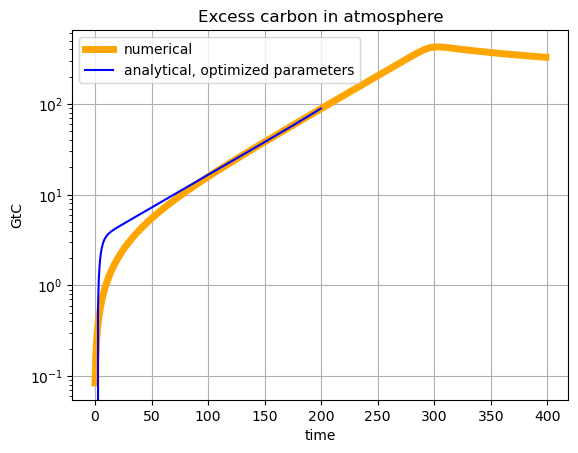

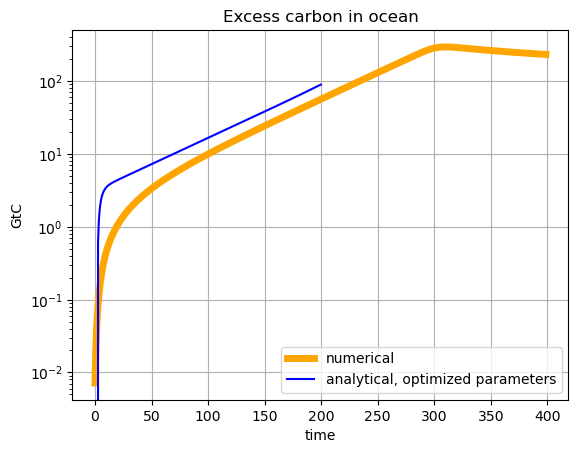

In [222]:
def func_Delta_C_analytical_Ca(t_array,c1,c2): # This is Eq. F2
    term1 = c1*nu1_a*np.exp(lambda1*t_array)
    term2 = c2*nu2_a*np.exp(lambda2*t_array)
    term3 = N_a*np.exp(k*t_array)
    result = term1 + term2 + term3
    return result

def func_Delta_C_analytical_Co(t_array,c1,c2): # This is Eq. F2
    term1 = c1*nu1_o*np.exp(lambda1*t_array)
    term2 = c2*nu2_o*np.exp(lambda2*t_array)
    term3 = N_o*np.exp(k*t_array)
    result = term1 + term2 + term3
    return result

# Doing the fit *without* zeroing out initial c value (atm)
c_fit_using_a = optimize.curve_fit(\
    func_Delta_C_analytical_Ca, xdata = t_array_fit, \
        ydata = Delta_C_atm_array_fit, p0=[0,0])[0]
print('c-values using atmosphere solution: ', c_fit_using_a)

# Doing the fit *without* zeroing out initial c value (ocean)
c_fit_using_o = optimize.curve_fit(\
    func_Delta_C_analytical_Co, xdata = t_array_fit, \
        ydata = Delta_C_ocean_array_fit, p0=[0,0])[0]
print('c-values using ocean solution: ', c_fit_using_o)

# Let's see how we did
Delta_C_analytical_Ca_fit = func_Delta_C_analytical_Ca(t_array_fit,c_fit_using_a[0],c_fit_using_a[1])
print('At t=0, Delta_C_atm ', Delta_C_analytical_Ca_fit[0])
plt.figure()
plt.semilogy(t_array_numerical,Delta_C_atm_array,color='orange',label='numerical',linewidth=linewidth)
plt.semilogy(t_array_fit,Delta_C_analytical_Ca_fit,color='blue',label='analytical, optimized parameters')
plt.grid(True)
plt.xlabel('time')
plt.ylabel('GtC')
plt.title('Excess carbon in atmosphere')
plt.legend()

# Let's see how we did
Delta_C_analytical_Co_fit = func_Delta_C_analytical_Co(t_array_fit,c_fit_using_o[0],c_fit_using_o[1])
print('At t=0, Delta_C_ocean ', Delta_C_analytical_Co_fit[0])
plt.figure()
plt.semilogy(t_array_numerical,Delta_C_ocean_array,color='orange',label='numerical',linewidth=linewidth)
plt.semilogy(t_array_fit,Delta_C_analytical_Ca_fit,color='blue',label='analytical, optimized parameters')
plt.grid(True)
plt.xlabel('time')
plt.ylabel('GtC')
plt.title('Excess carbon in ocean')
plt.legend()

### Interpretation of these results
The values of $c_1$ returned by fits to the numerical results for atm and ocean "agree" in the sense that they are both on the order of $10^{-5}$. 

By contrast, the values of $c_2$ returned by fits to the numerical results for atm and ocean seem vastly different, at about $5$ and $-5$. 

### Getting $c_1$ and $c_2$ with a best-fit match to the numerical results (alternative formulation)
Below we repeat what we just did, but using functions that subtract the time=0 concentrations. 

c-values using atmosphere solution:  [1.48153511e-05 1.94398608e+00]
c-values using ocean solution:  [ 1.91876907e-05 -1.57541067e+00]
At t=0, Delta_C_atm  0.0
At t=0, Delta_C_ocean  0.0


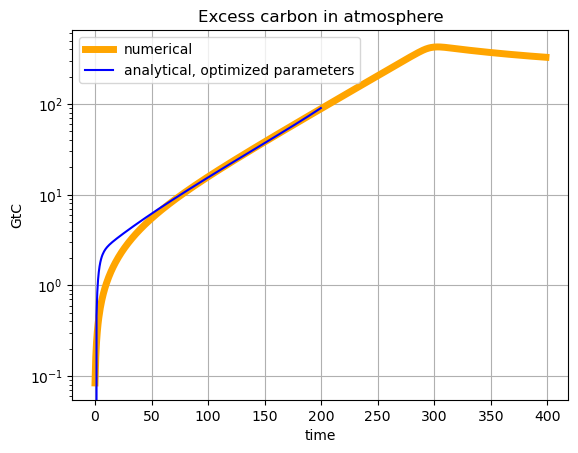

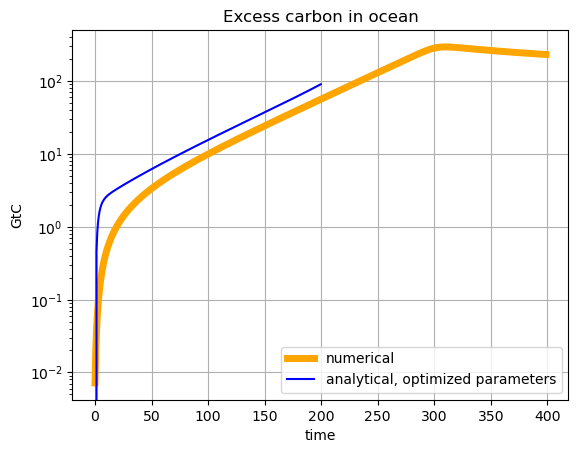

In [226]:
# The proposed function for Delta C_atm 
### This picks up the following global variables:
### k, lambda1, lambda2, nu1_a, nu2_a, N_a
def func_Delta_C_analytical_Ca(t_array,c1,c2): # This is Eq. F1
    term1 = c1*nu1_a*np.exp(lambda1*t_array)
    term2 = c2*nu2_a*np.exp(lambda2*t_array)
    term3 = N_a*np.exp(k*t_array)
    result = term1 + term2 + term3
    return result-result[0]

def func_Delta_C_analytical_Co(t_array,c1,c2): # This is Eq. F2
    term1 = c1*nu1_o*np.exp(lambda1*t_array)
    term2 = c2*nu2_o*np.exp(lambda2*t_array)
    term3 = N_o*np.exp(k*t_array)
    result = term1 + term2 + term3
    return result-result[0]


# Doing the fit with zeroing out initial C value (atm)
c_fit_using_a = optimize.curve_fit(\
    func_Delta_C_analytical_Ca, xdata = t_array_fit, \
        ydata = Delta_C_atm_array_fit, p0=[0,0])[0]
print('c-values using atmosphere solution: ', c_fit_using_a)

# Doing the fit with zeroing out initial C value (ocean)
c_fit_using_o = optimize.curve_fit(\
    func_Delta_C_analytical_Co, xdata = t_array_fit, \
        ydata = Delta_C_ocean_array_fit, p0=[0,0])[0]
print('c-values using ocean solution: ', c_fit_using_o)

# Let's see how we did
Delta_C_analytical_Ca_fit = func_Delta_C_analytical_Ca(t_array_fit,c_fit_using_a[0],c_fit_using_a[1])
print('At t=0, Delta_C_atm ', Delta_C_analytical_Ca_fit[0])
plt.figure()
plt.semilogy(t_array_numerical,Delta_C_atm_array,color='orange',label='numerical',linewidth=linewidth)
plt.semilogy(t_array_fit,Delta_C_analytical_Ca_fit,color='blue',label='analytical, optimized parameters')
plt.grid(True)
plt.xlabel('time')
plt.ylabel('GtC')
plt.title('Excess carbon in atmosphere')
plt.legend()

# Let's see how we did
Delta_C_analytical_Co_fit = func_Delta_C_analytical_Co(t_array_fit,c_fit_using_o[0],c_fit_using_o[1])
print('At t=0, Delta_C_ocean ', Delta_C_analytical_Co_fit[0])
plt.figure()
plt.semilogy(t_array_numerical,Delta_C_ocean_array,color='orange',label='numerical',linewidth=linewidth)
plt.semilogy(t_array_fit,Delta_C_analytical_Ca_fit,color='blue',label='analytical, optimized parameters')
plt.grid(True)
plt.xlabel('time')
plt.ylabel('GtC')
plt.title('Excess carbon in ocean')
plt.legend()

### Interpretation of these results
As before, values of $c_1$ returned by fits to the numerical results for atm and ocean "agree" in the sense that they are both on the order of $10^{-5}$. 

Also like the previous results, the values of $c_2$ returned by fits to the numerical results for atm and ocean seem vastly different, here at about $2$ and $-2$. 

### Emission scenarios
The code below creates new emission scenarios based on the reference one loaded in above here (in the dictionary epsdictionary), but with varying decarbonization times.

{'dataframe':             time  emissions
 0    1750.000000   0.134987
 1    1750.667780   0.136492
 2    1751.335559   0.138013
 3    1752.003339   0.139552
 4    1752.671119   0.141107
 ..           ...        ...
 595  2147.328881   4.000000
 596  2147.996661   4.000000
 597  2148.664441   4.000000
 598  2149.332220   4.000000
 599  2150.000000   4.000000
 
 [600 rows x 2 columns],
 't_0': 2003,
 'eps_0': 9,
 't_peak': 2040,
 't_decarb': 15,
 'k': 0.0166}

peak 14.792264030347214 434
peak 11.571316374773483 434
peak 11.571316374773483 434
peak 11.571316374773483 434


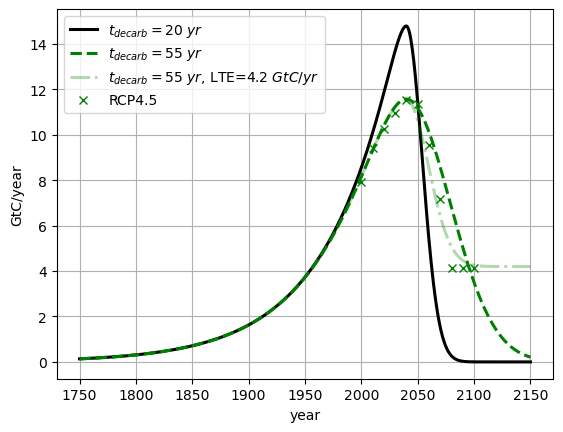

In [230]:
display(epsdictionary)
t_start = time[0]
t_stop = time[-1]
nsteps = len(time)
eps_0 = epsdictionary['eps_0']
t_0 = epsdictionary['t_0']
t_peak = epsdictionary['t_peak']
t, myeps1 = cl.MakeEmissionsScenarioLTE(t_start,t_stop,nsteps,k,eps_0,t_0,t_peak,20,0)
t, myeps2 = cl.MakeEmissionsScenarioLTE(t_start,t_stop,nsteps,k,eps_0,t_0,t_peak,55,0)
t, myeps3 = cl.MakeEmissionsScenarioLTE(t_start,t_stop,nsteps,k,eps_0,t_0,t_peak,55,0)
t, myeps4 = cl.MakeEmissionsScenarioLTE(t_start,t_stop,nsteps,k,eps_0,t_0,t_peak,55,4.2,.5)

tRCP45 = np.array([2000,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100])
eRCP45 = np.array([1.23,1.46,1.59,1.70,1.79,1.76,1.48,1.11,0.64,0.64,0.64])*10/1.55


lw = 2.2
plt.figure()
plt.plot(t,myeps1,'-', color='k', linewidth=lw,label='$t_{decarb}=20 \ yr$')
plt.plot(t,myeps2,'--',color='g', linewidth=lw,label='$t_{decarb}=55 \ yr$')
# plt.plot(t,myeps3,'-.',color='b', linewidth=lw,label='$t_{decarb}=55 \ yr$')
plt.plot(t,myeps4,'-.',color='g', linewidth=lw,label='$t_{decarb}=55 \ yr$, LTE=4.2 $GtC/yr$', alpha=0.3)
plt.plot(tRCP45,eRCP45,'x',color='g', linewidth=lw,label='RCP4.5')
plt.grid(True)
plt.xlabel('year')
plt.ylabel('GtC/year')
plt.legend()

### Self-consistency report
Below, we print results currently returned by cl computed here vs what is returned by the library functions.

In [232]:
ClimateParams = cl.CreateClimateParams(epsdictionary)
ClimateState = cl.CreateClimateState(ClimateParams)
display(ClimateParams)
display(ClimateState)
print('Computed here ...')
print('k_la =',k_la)
print('k_al0 =',k_al0)
print('k_al1 =',k_al1)
print('k_oa =',k_oa)
print('k_ao =',k_ao)
print('k =',k)
print('DC (AKA s_H) =',DC)
print('CS (AKA s_C =',CS)
print('C_atm_preind =', C_atm_preind)
print('AS (AKA s_alpha) =',AS)
print('C_ocean_preind =', C_ocean_preind)
print('k_al1_Tstar (AKA T_(CO_2 f,thresh)) =', k_al1_Tstar_opt)
print('k_al1_deltaT (AKA T_(CO_2 f,trans)) =', k_al1_deltaT_opt)
print('fractional_k_al1_floor (AKA σ_(CO_2 f,+∞))) =', fractional_k_al1_floor_opt)
print('fractional_albedo_floor (AKA σ_(ice/albedo,+∞))', fractional_albedo_floor)

{'k_la': 120,
 'k_al0': 110.6842105263158,
 'k_al1': 0.015789473684210527,
 'k_oa': 0.1694051282051282,
 'k_ao': 0.11794871794871795,
 'k': 0.0166,
 'DC': 0.0321,
 'climate sensitivity': 0.005084745762711864,
 'C_atm 2003': 780,
 'F_ao 2003': 92,
 'F_oa 2003': 90,
 'preindustrial C_atm': 590,
 'albedo sensitivity': -102.9948207250004,
 'preindustrial albedo': 0.3,
 'preindustrial pH': 8.2,
 'starting time': np.float64(1750.0),
 'k_al1_Tstar': 1.43,
 'k_al1_deltaT': 0.471,
 'fractional_k_al1_floor': 0.684,
 'albedo_Tstar': 2,
 'albedo_delta_T': 1,
 'fractional_albedo_floor': 0.9860834426115428}

{'C_atm': 590,
 'C_ocean': 410.78888417993585,
 'albedo': 0.3,
 'T_anomaly': 0,
 'pH': 8.2,
 'time': np.float64(1750.0)}

Computed here ...
k_la = 120
k_al0 = 110.6842105263158
k_al1 = 0.015789473684210527
k_oa = 0.1694051282051282
k_ao = 0.11794871794871795
k = 0.0166
DC (AKA s_H) = 0.03213114754098361
CS (AKA s_C = 0.005084745762711864
C_atm_preind = 590.0
AS (AKA s_alpha) = -102.82666535490968
C_ocean_preind = 410.78888417993585
k_al1_Tstar (AKA T_(CO_2 f,thresh)) = 1.429297013609816
k_al1_deltaT (AKA T_(CO_2 f,trans)) = 0.4734763952137283
fractional_k_al1_floor (AKA σ_(CO_2 f,+∞))) = 0.6837800799783833
fractional_albedo_floor (AKA σ_(ice/albedo,+∞)) 0.9860606844694794
